Comparison of Model Performance Under Different Feature Counts

In [ ]:
import openai
import re
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

load_dotenv()  
openai.api_key = os.getenv("openai_key")

def feature_selection_by_count(feature_counts):
    results = []
    df = pd.read_csv(r"C:\Users\yicheng\Desktop\data\csv\merged_cleaned_dataset.csv")
    y = df["attack_cat"].values.ravel()

    with open(r"C:\Users\yicheng\Desktop\data\statistics\basic_features.txt", "r", encoding="utf-8") as f:
        basic_features_content = f.read()

    with open(r"C:\Users\yicheng\Desktop\data\csv\NUSW-NB15_features.csv", "r", encoding="latin1") as f:
        feature_description = f.read()
    
    for k in feature_counts:
        print(f"\n Running Agent feature selection for {k} features...\n")

        while True:
            # create the prompt for OpenAI
            prompt = generate_fixed_count_prompt(feature_description, basic_features_content, k)
            # get the response from OpenAI
            response = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}]
            )
            result = response['choices'][0]['message']['content']
           # read the result and parse the selected features
            matches_code_block = re.findall(r"`{1,3}([^`]+?)`{1,3}", result)
            selected_features = None
            if matches_code_block:
                feature_list_str = matches_code_block[-1]
                selected_features = [f.strip() for f in feature_list_str.split(',') if f.strip()]
            if selected_features is None:
                matches_inline = re.findall(r"^\s*([\w\d_]+(?:,\s*[\w\d_]+){5,})\s*$", result, re.MULTILINE)
                if matches_inline:
                    feature_list_str = matches_inline[-1]
                    selected_features = [f.strip() for f in feature_list_str.split(',') if f.strip()]
            if selected_features is None:
                print(" GPT response parsing failed. Raw result:\n", result)
                continue  
            if len(selected_features) != k:
                print(f" GPT returned {len(selected_features)} features, expected {k}. Retrying...\n")
                continue  
            print("Successful GPT result:\n", result)
            print(f" GPT selected {len(selected_features)} features: {selected_features}")
            break 
        # train the models with the selected features
        X = df[selected_features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        rf_start = time.time()
        rf_result = train_rf_model(X_train, X_test, y_train, y_test)
        rf_result["training_time"] = time.time() - rf_start

        lstm_start = time.time()
        lstm_result = train_lstm_model(X_train, y_train, X_test, y_test, params={"epochs": 3})
        lstm_result["training_time"] = time.time() - lstm_start

        transformer_start = time.time()
        transformer_result = train_transformer_model(X_train, y_train, X_test, y_test, params={"epochs": 3})
        transformer_result["training_time"] = time.time() - transformer_start

        results.append({
            "num_features": k,
            "selected_features": selected_features,
            "rf": rf_result,
            "lstm": lstm_result,
            "transformer": transformer_result
        })

    # save the results to a JSON file
    with open("different_number_of_features.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)

    print("\n Experiments of different number of features finished and saved.")

# generate the prompt for OpenAI
def generate_fixed_count_prompt(feature_description, basic_features_content, num_features):
    return f"""
Role: You are a top-tier cybersecurity expert specializing in network intrusion detection, feature engineering, and traffic behavior modeling.  You are now facing a new detection environment, where we must build a highly generalizable and efficient signature feature set. Your task is to recommend exactly **{num_features}** features from a given list.

Background and Data Source: You are working with a highly realistic network traffic data from the authoritative UNSW-NB15 dataset, which was carefully constructed in a professional cyber range environment (Australian Cyber Security Centre). The environment uses the IXIA PerfectStorm tool to simulate a mix of real normal traffic with modern attack traffic from the CVE library. The entire network topology consists of three servers, two routers and a firewall configured to allow all traffic to pass through. The data was captured by the tcpdump tool and the final 49 features were extracted using Argus, Bro-IDS and custom algorithms. This context ensured that the data was realistic and complex, very close to real-world attack and defence scenarios.
An explanation of the meaning of each feature column is included below:
{feature_description}

Environment Overview:  
In this environment, the volume of normal and attack traffic is extremely unbalanced, as detailed below:
- Normal:              1,959,773
- Exploits:              27,599
- Generic:               25,378
- Fuzzers:               21,795
- Reconnaissance:        13,357
- DoS:                    5,665
- Analysis:               2,185
- Backdoors:              1,984
- Shellcode:              1,511
- Worms:                    171

These proportions reflect the real-world class imbalance problem faced in production environments and underscore the need for robust, highly discriminative features that generalize well across both common and rare attack types.
You are to choose {num_features} features to maximize general attack detection performance across all types, especially those with rare samples (e.g., Worms, Shellcode). Avoid redundancy and prioritize generalizability.

The following is the combined result of all such comparisons, listing the most discriminative features for each attack type:
{basic_features_content}


You must choose exactly {num_features} unique features from this list:
`dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth, res_bdy_len, ct_flw_http_mthd, is_ftp_login, dttl, is_sm_ips_ports, stime`

If {num_features} == 30, features = `dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth, res_bdy_len, ct_flw_http_mthd, is_ftp_login, dttl, is_sm_ips_ports, stime`

Please follow the format below strictly, no explanation needs to be added, only the value of the feature being selected.
Output Format: (on a new line, please output only the selected features as a plain comma-separated list)
`feature1, feature2, feature3, ...`

"""
feature_selection_by_count(feature_counts=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])



 Running Agent feature selection for 6 features...

Successful GPT result:
 sbytes, dbytes, spkts, sttl, state, ct_dst_src_ltm
 GPT selected 6 features: ['sbytes', 'dbytes', 'spkts', 'sttl', 'state', 'ct_dst_src_ltm']
Epoch 1/3


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.9609 - loss: 0.0251 - val_accuracy: 0.9692 - val_loss: 0.0132
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.9689 - loss: 0.0135 - val_accuracy: 0.9710 - val_loss: 0.0128
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.9697 - loss: 0.0132 - val_accuracy: 0.9689 - val_loss: 0.0127


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step - accuracy: 0.9105 - loss: 8.4778e-04 - val_accuracy: 0.9583 - val_loss: 6.2748e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step - accuracy: 0.9441 - loss: 6.8128e-04 - val_accuracy: 0.9542 - val_loss: 6.0130e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 115s 4ms/step - accuracy: 0.9462 - loss: 6.5875e-04 - val_accuracy: 0.9529 - val_loss: 6.0553e-04

 Running Agent feature selection for 8 features...

Successful GPT result:
 `sbytes, dbytes, spkts, dpkts, sload, dload, sttl, state`
 GPT selected 8 features: ['sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'sttl', 'state']
Epoch 1/3


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9590 - loss: 0.0263 - val_accuracy: 0.9663 - val_loss: 0.0155
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.9655 - loss: 0.0157 - val_accuracy: 0.9655 - val_loss: 0.0153
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9657 - loss: 0.0155 - val_accuracy: 0.9661 - val_loss: 0.0149


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - accuracy: 0.9078 - loss: 9.1856e-04 - val_accuracy: 0.9574 - val_loss: 7.5738e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.9405 - loss: 8.2760e-04 - val_accuracy: 0.9507 - val_loss: 7.2624e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.9424 - loss: 7.7051e-04 - val_accuracy: 0.9527 - val_loss: 7.2751e-04


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


 Running Agent feature selection for 10 features...

Successful GPT result:
 `dur, sbytes, dbytes, spkts, dpkts, sload, dload, sttl, ct_srv_dst, ct_dst_ltm`
 GPT selected 10 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'sttl', 'ct_srv_dst', 'ct_dst_ltm']
Epoch 1/3


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9613 - loss: 0.0260 - val_accuracy: 0.9715 - val_loss: 0.0123
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9705 - loss: 0.0127 - val_accuracy: 0.9714 - val_loss: 0.0118
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9716 - loss: 0.0122 - val_accuracy: 0.9730 - val_loss: 0.0115


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - accuracy: 0.8630 - loss: 8.6630e-04 - val_accuracy: 0.9539 - val_loss: 6.1556e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - accuracy: 0.9220 - loss: 7.0548e-04 - val_accuracy: 0.9581 - val_loss: 6.0805e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9229 - loss: 6.8482e-04 - val_accuracy: 0.9561 - val_loss: 6.1290e-04

 Running Agent feature selection for 12 features...

Successful GPT result:
 ```
dur, sbytes, dbytes, sload, dload, spkts, dpkts, tcprtt, synack, ackdat, ct_flw_http_mthd, service
```
 GPT selected 12 features: ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'dpkts', 'tcprtt', 'synack', 'ackdat', 'ct_flw_http_mthd', 'service']
Epoch 1/3


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9576 - loss: 0.0255 - val_accuracy: 0.9670 - val_loss: 0.0139
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9667 - loss: 0.0142 - val_accuracy: 0.9691 - val_loss: 0.0135
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.9673 - loss: 0.0138 - val_accuracy: 0.9674 - val_loss: 0.0133


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 127s 5ms/step - accuracy: 0.8220 - loss: 8.7488e-04 - val_accuracy: 0.9355 - val_loss: 6.6108e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - accuracy: 0.9084 - loss: 7.0869e-04 - val_accuracy: 0.9292 - val_loss: 6.3170e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 131s 5ms/step - accuracy: 0.9096 - loss: 6.9844e-04 - val_accuracy: 0.9126 - val_loss: 6.4616e-04

 Running Agent feature selection for 14 features...

Successful GPT result:
 ```
dur,sbytes,dbytes,spkts,dpkts,sload,dload,smeansz,dmeansz,sttl,state,service,proto,tcprtt
```
 GPT selected 14 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt']


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.9657 - loss: 0.0191 - val_accuracy: 0.9737 - val_loss: 0.0098
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9738 - loss: 0.0101 - val_accuracy: 0.9757 - val_loss: 0.0092
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 99s 4ms/step - accuracy: 0.9752 - loss: 0.0095 - val_accuracy: 0.9760 - val_loss: 0.0089
Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 284s 11ms/step - accuracy: 0.9044 - loss: 8.3848e-04 - val_accuracy: 0.9611 - val_loss: 5.5208e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 301s 10ms/step - accuracy: 0.9378 - loss: 5.7296e-04 - val_accuracy: 0.9571 - val_loss: 4.4868e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 203s 8ms/step - accuracy: 0.9453 - loss: 5.3800e-04 - val_accuracy: 0.9623 - val_loss: 4.4791e-04

 Running Agent feature selection for 16 features...

Successful GPT result:
 ```
dur,sbytes,dbytes,spkts,dpkts,sload,dload,smeansz,sttl,state,service,proto,tcprtt,ackdat,ct_srv_s

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9682 - loss: 0.0184 - val_accuracy: 0.9755 - val_loss: 0.0085
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.9753 - loss: 0.0087 - val_accuracy: 0.9765 - val_loss: 0.0082
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9761 - loss: 0.0083 - val_accuracy: 0.9775 - val_loss: 0.0078
Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 176s 7ms/step - accuracy: 0.9096 - loss: 8.1573e-04 - val_accuracy: 0.9573 - val_loss: 4.5872e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 176s 7ms/step - accuracy: 0.9419 - loss: 5.2465e-04 - val_accuracy: 0.9613 - val_loss: 4.6818e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 177s 7ms/step - accuracy: 0.9464 - loss: 4.8343e-04 - val_accuracy: 0.9616 - val_loss: 4.3191e-04

 Running Agent feature selection for 18 features...

Successful GPT result:
 ```
dur,sbytes,dbytes,spkts,dpkts,sload,dload,smeansz,dmeansz,sttl,state,proto,tcprtt,ct_srv_src,ct_dst

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9684 - loss: 0.0181 - val_accuracy: 0.9759 - val_loss: 0.0087
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9751 - loss: 0.0091 - val_accuracy: 0.9767 - val_loss: 0.0082
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9761 - loss: 0.0086 - val_accuracy: 0.9772 - val_loss: 0.0080


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 216s 8ms/step - accuracy: 0.8983 - loss: 7.8195e-04 - val_accuracy: 0.9584 - val_loss: 4.6860e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 185s 7ms/step - accuracy: 0.9338 - loss: 5.6010e-04 - val_accuracy: 0.9633 - val_loss: 5.2982e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 186s 7ms/step - accuracy: 0.9483 - loss: 4.9653e-04 - val_accuracy: 0.9624 - val_loss: 4.4607e-04

 Running Agent feature selection for 20 features...

Successful GPT result:
 ```
dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm
```
 GPT selected 20 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm']


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9687 - loss: 0.0178 - val_accuracy: 0.9758 - val_loss: 0.0085
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9758 - loss: 0.0087 - val_accuracy: 0.9768 - val_loss: 0.0079
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9765 - loss: 0.0082 - val_accuracy: 0.9776 - val_loss: 0.0076


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 257s 10ms/step - accuracy: 0.9158 - loss: 7.8319e-04 - val_accuracy: 0.9354 - val_loss: 5.2221e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 256s 10ms/step - accuracy: 0.9393 - loss: 5.3562e-04 - val_accuracy: 0.9584 - val_loss: 4.3188e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 258s 10ms/step - accuracy: 0.9430 - loss: 5.1803e-04 - val_accuracy: 0.9610 - val_loss: 4.2030e-04

 Running Agent feature selection for 22 features...

Successful GPT result:
 ```
dur,sbytes,dbytes,spkts,dpkts,sload,dload,smeansz,dmeansz,sttl,state,service,proto,tcprtt,synack,ackdat,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_src_ltm
```
 GPT selected 22 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_src_ltm']


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.9694 - loss: 0.0174 - val_accuracy: 0.9766 - val_loss: 0.0081
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.9762 - loss: 0.0084 - val_accuracy: 0.9771 - val_loss: 0.0078
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9770 - loss: 0.0080 - val_accuracy: 0.9772 - val_loss: 0.0075


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 251s 10ms/step - accuracy: 0.9099 - loss: 8.2579e-04 - val_accuracy: 0.9522 - val_loss: 4.3286e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 264s 10ms/step - accuracy: 0.9396 - loss: 5.2523e-04 - val_accuracy: 0.9593 - val_loss: 4.1692e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 268s 10ms/step - accuracy: 0.9470 - loss: 4.8034e-04 - val_accuracy: 0.9545 - val_loss: 4.1176e-04

 Running Agent feature selection for 24 features...

Successful GPT result:
 ```
dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth
```
 GPT selected 24 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.9691 - loss: 0.0175 - val_accuracy: 0.9765 - val_loss: 0.0081
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9764 - loss: 0.0083 - val_accuracy: 0.9773 - val_loss: 0.0077
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9769 - loss: 0.0080 - val_accuracy: 0.9776 - val_loss: 0.0074


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 256s 10ms/step - accuracy: 0.8997 - loss: 8.0572e-04 - val_accuracy: 0.9499 - val_loss: 5.0684e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 242s 9ms/step - accuracy: 0.9351 - loss: 5.2647e-04 - val_accuracy: 0.9554 - val_loss: 4.3132e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 189s 7ms/step - accuracy: 0.9458 - loss: 4.8521e-04 - val_accuracy: 0.9581 - val_loss: 4.8706e-04

 Running Agent feature selection for 26 features...

Successful GPT result:
 ```
dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth, res_bdy_len, ct_flw_http_mthd
```
 GPT selected 26 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_s

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 130s 5ms/step - accuracy: 0.9703 - loss: 0.0170 - val_accuracy: 0.9767 - val_loss: 0.0081
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step - accuracy: 0.9759 - loss: 0.0086 - val_accuracy: 0.9771 - val_loss: 0.0076
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - accuracy: 0.9769 - loss: 0.0079 - val_accuracy: 0.9774 - val_loss: 0.0075
Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 346s 13ms/step - accuracy: 0.8977 - loss: 7.9863e-04 - val_accuracy: 0.9021 - val_loss: 6.5164e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 372s 14ms/step - accuracy: 0.9329 - loss: 5.3911e-04 - val_accuracy: 0.9620 - val_loss: 4.5322e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 366s 14ms/step - accuracy: 0.9450 - loss: 4.8435e-04 - val_accuracy: 0.9593 - val_loss: 4.3272e-04

 Running Agent feature selection for 28 features...

 GPT returned 27 features, expected 28. Retrying...

 GPT returned 27 features, expected 28. Retrying...

 GPT returned 2

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.9696 - loss: 0.0170 - val_accuracy: 0.9769 - val_loss: 0.0081
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.9761 - loss: 0.0084 - val_accuracy: 0.9773 - val_loss: 0.0076
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step - accuracy: 0.9772 - loss: 0.0079 - val_accuracy: 0.9776 - val_loss: 0.0074


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 267s 10ms/step - accuracy: 0.9182 - loss: 8.0333e-04 - val_accuracy: 0.9541 - val_loss: 5.8779e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 384s 15ms/step - accuracy: 0.9459 - loss: 5.6267e-04 - val_accuracy: 0.9510 - val_loss: 4.9515e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 359s 14ms/step - accuracy: 0.9523 - loss: 5.0005e-04 - val_accuracy: 0.9611 - val_loss: 4.2771e-04

 Running Agent feature selection for 30 features...

Successful GPT result:
 ```
dur,sbytes,dbytes,spkts,dpkts,sload,dload,smeansz,dmeansz,sttl,state,service,proto,tcprtt,synack,ackdat,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,trans_depth,res_bdy_len,ct_flw_http_mthd,is_ftp_login,dttl,is_sm_ips_ports,stime
```
 GPT selected 30 features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'c

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.9706 - loss: 0.0167 - val_accuracy: 0.9759 - val_loss: 0.0081
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9762 - loss: 0.0084 - val_accuracy: 0.9774 - val_loss: 0.0075
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9769 - loss: 0.0079 - val_accuracy: 0.9777 - val_loss: 0.0074
Epoch 1/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 232s 9ms/step - accuracy: 0.9192 - loss: 8.1863e-04 - val_accuracy: 0.9514 - val_loss: 5.2866e-04
Epoch 2/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - accuracy: 0.9491 - loss: 5.2461e-04 - val_accuracy: 0.9602 - val_loss: 4.4067e-04
Epoch 3/3
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 299s 12ms/step - accuracy: 0.9529 - loss: 4.7160e-04 - val_accuracy: 0.9663 - val_loss: 4.7895e-04

 Experiments of different number of features finished and saved.


Analyze the Impact of Different Feature Quantities on Model Performance

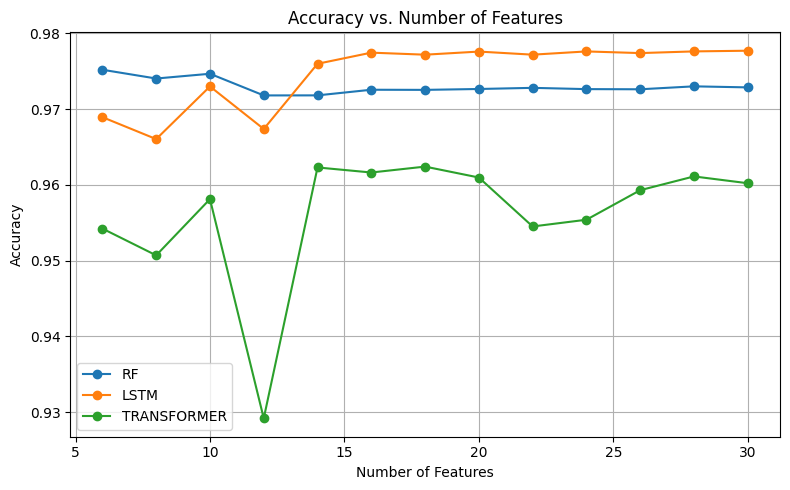

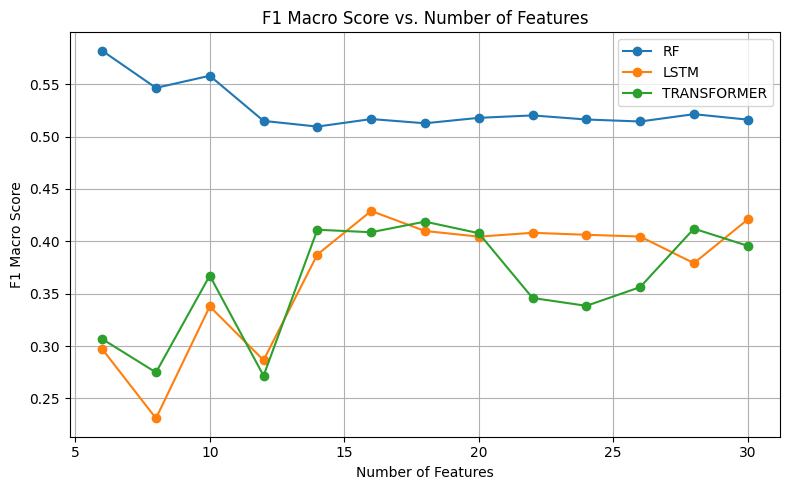

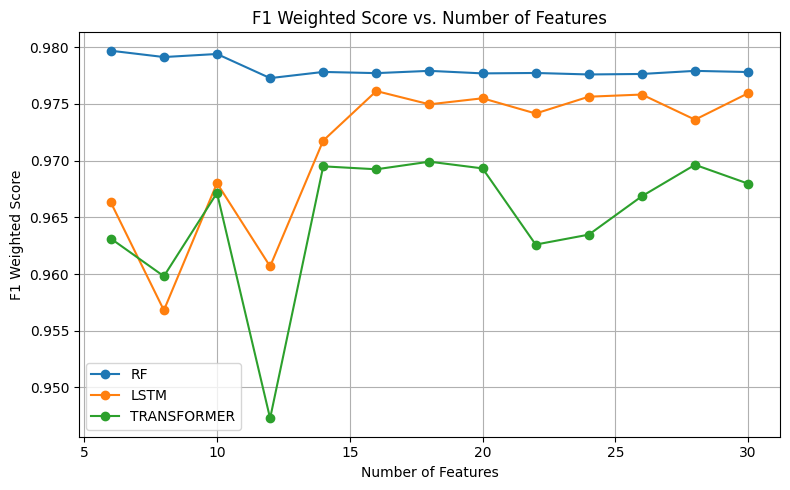

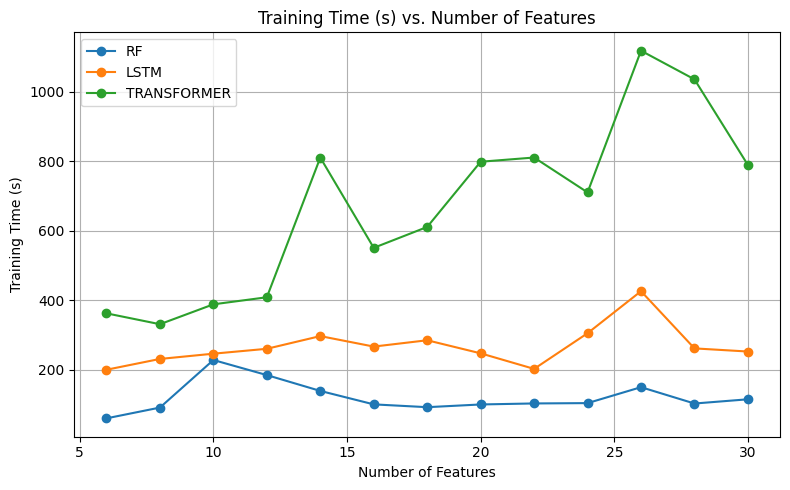

In [ ]:
import json
import matplotlib.pyplot as plt

file_path = "C:/Users/yicheng/Desktop/summer project/code/different_number_of_features.json"
with open(file_path, "r") as f:
    data_list = json.load(f)

# initialize storage structure
metrics_by_model = {
    "rf": {"num_features": [], "accuracy": [], "f1_macro": [], "f1_weighted": [], "training_time": []},
    "lstm": {"num_features": [], "accuracy": [], "f1_macro": [], "f1_weighted": [], "training_time": []},
    "transformer": {"num_features": [], "accuracy": [], "f1_macro": [], "f1_weighted": [], "training_time": []}
}

# read and process the data
for entry in data_list:
    num_feats = entry.get("num_features")
    for model in ["rf", "lstm", "transformer"]:
        model_data = entry.get(model, {})
        metrics = model_data.get("metrics", {})
        weighted_f1 = metrics.get("classification_report", {}).get("weighted avg", {}).get("f1-score", 0)
        metrics_by_model[model]["num_features"].append(num_feats)
        metrics_by_model[model]["accuracy"].append(metrics.get("accuracy", 0))
        metrics_by_model[model]["f1_macro"].append(metrics.get("f1_macro", 0))
        metrics_by_model[model]["f1_weighted"].append(weighted_f1)
        metrics_by_model[model]["training_time"].append(model_data.get("training_time", 0))

def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    for model in metrics_by_model:
        x = metrics_by_model[model]["num_features"]
        y = metrics_by_model[model][metric_name]
        plt.plot(x, y, marker='o', label=model.upper())
    plt.xlabel("Number of Features")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. Number of Features")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric("accuracy", "Accuracy")
plot_metric("f1_macro", "F1 Macro Score")
plot_metric("f1_weighted", "F1 Weighted Score")  
plot_metric("training_time", "Training Time (s)")


Use OpenAI to Recommend Features for Each Model

In [ ]:
import openai
import re
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

load_dotenv()  
openai.api_key = os.getenv("openai_key")

with open(r"C:\Users\yicheng\Desktop\data\statistics\basic_features.txt", "r", encoding="utf-8") as f:
    basic_features_content = f.read()

with open(r"C:\Users\yicheng\Desktop\data\csv\NUSW-NB15_features.csv", "r", encoding="latin1") as f:
    feature_description = f.read()
    

# construct the agent-assisted feature selection process
def run_agent_assisted_feature_selection(num_rounds=5):
    # save history of feature selection and model performance
    history = {"rf": [], "lstm": [], "transformer": []}
    current_prompt = generate_initial_prompt(feature_description, basic_features_content)
    

    for round_idx in range(1, num_rounds + 1):
        print(f"\n Feature Selecting Round {round_idx}\n")
        # use OpenAI to generate features
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": current_prompt}]
        )
        result = response['choices'][0]['message']['content']
        print(result)
        
        # read the GPT output and extract features
        selected_features = {}

        model_tags = {
            "rf": r"\[Random Forest\]\s*:\s*'([^']+)'",
            "lstm": r"\[LSTM\]\s*:\s*'([^']+)'",
            "transformer": r"\[Transformer\]\s*:\s*'([^']+)'",
            }

        extracted = {}

        # match each model's features using regex
        for model_key, pattern in model_tags.items():
            match = re.search(pattern, result, re.IGNORECASE)
            if match:
                feature_str = match.group(1)
                feature_list = [f.strip() for f in feature_str.split(',') if f.strip()]
                extracted[model_key] = feature_list
        # check features extracted
        if all(k in extracted for k in ["rf", "lstm", "transformer"]):
            selected_features = extracted
        else:
            raise ValueError("Error: Failed to extract all three model feature sets from GPT output.")

        for model_key in selected_features:
            print(f"{model_key.upper()} model selected {len(selected_features[model_key])} features: {selected_features[model_key]}")
        print('\n')

        # prepare the dataset
        df = pd.read_csv(r"C:\Users\yicheng\Desktop\data\csv\merged_cleaned_dataset.csv")
        y = df["attack_cat"].values.ravel()
        X_rf = df[selected_features["rf"]]
        X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y, test_size=0.2, random_state=42, stratify=y)
        X_lstm = df[selected_features["lstm"]]
        X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)
        X_trans = df[selected_features["transformer"]]
        X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y, test_size=0.2, random_state=42, stratify=y)


        # train models
        rf_results = train_rf_model(X_rf_train, X_rf_test, y_rf_train, y_rf_test)
        print('Random forest finished.\n')
        lstm_results = train_lstm_model(X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test, params={"epochs": 3})
        print('Lstm finished.\n')
        transformer_results = train_transformer_model(X_trans_train, y_trans_train, X_trans_test, y_trans_test, params={"epochs": 3})
        print('Transformer finished.\n')

        # save results to history
        history["rf"].append({"round": round_idx, "features": selected_features["rf"],
                              "metrics": {"accuracy": rf_results["metrics"]["accuracy"], 
                                          "f1_macro": rf_results["metrics"]["f1_macro"], 
                                          "f1_weighted": rf_results["metrics"]["f1_weighted"],
                                          "classification_report": rf_results["metrics"]["classification_report"], 
                                          "training_time": rf_results["training_time"], 
                                          "epoch_metrics": rf_results["epoch_metrics"]
                                          }})
        history["lstm"].append({"round": round_idx,"features": selected_features["lstm"],
                                "metrics": {"accuracy": lstm_results["metrics"]["accuracy"], 
                                          "f1_macro": lstm_results["metrics"]["f1_macro"], 
                                          "f1_weighted": lstm_results["metrics"]["f1_weighted"],
                                          "classification_report": lstm_results["metrics"]["classification_report"], 
                                          "training_time": lstm_results["training_time"], 
                                          "epoch_metrics": lstm_results["epoch_metrics"]
                                          }})
        history["transformer"].append({"round": round_idx,"features": selected_features["transformer"],
                                       "metrics": {"accuracy": transformer_results["metrics"]["accuracy"], 
                                          "f1_macro": transformer_results["metrics"]["f1_macro"], 
                                          "f1_weighted": transformer_results["metrics"]["f1_weighted"],
                                          "classification_report": transformer_results["metrics"]["classification_report"], 
                                          "training_time": transformer_results["training_time"], 
                                          "epoch_metrics": transformer_results["epoch_metrics"]
                                          }})

        # construct the next round prompt
        current_prompt = build_next_round_prompt(feature_description, basic_features_content, history)

    # save all history
    with open("models_feature_selection_history.json", "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)

    print("\n Feature selecting finished.json")
    

# initial prompt for the first round
def generate_initial_prompt(feature_description, basic_features_content):
    return f"""
Role: You are a top-tier cybersecurity expert specializing in network intrusion detection, feature engineering, and traffic behavior modeling. You are now facing a new detection environment, where we must build a highly generalizable and efficient signature feature set.


Background and Data Source: You are working with a highly realistic network traffic data from the authoritative UNSW-NB15 dataset, which was carefully constructed in a professional cyber range environment (Australian Cyber Security Centre). The environment uses the IXIA PerfectStorm tool to simulate a mix of real normal traffic with modern attack traffic from the CVE library. The entire network topology consists of three servers, two routers and a firewall configured to allow all traffic to pass through. The data was captured by the tcpdump tool and the final 49 features were extracted using Argus, Bro-IDS and custom algorithms. This context ensured that the data was realistic and complex, very close to real-world attack and defence scenarios.
An explanation of the meaning of each feature column is included below:
{feature_description}

Environment Overview:  
In this environment, the volume of normal and attack traffic is extremely unbalanced, as detailed below:

- Normal:              1,959,773
- Exploits:              27,599
- Generic:               25,378
- Fuzzers:               21,795
- Reconnaissance:        13,357
- DoS:                    5,665
- Analysis:               2,185
- Backdoors:              1,984
- Shellcode:              1,511
- Worms:                    171

These proportions reflect the real-world class imbalance problem faced in production environments and underscore the need for robust, highly discriminative features that generalize well across both common and rare attack types.

Input Information:  
To better understand discriminative features, we have conducted per-attack-type binary comparisons, each comparing the normal class with a **single attack type** using equal sample sizes (1:1 balanced). From each comparison, the top **20 most useful features** were selected using statistical methods.

The following is the combined result of all such comparisons, listing the most discriminative features for each attack type:

{basic_features_content}


Model-Specific Objectives:
You must now recommend feature sets tailored for three different models:

1. **Random Forest**  
   - Handles high-dimensional, sparse, and categorical features well.  
   - Robust to feature correlation.  
   - Suitable for general pattern learning across all traffic types.

2. **LSTM (Recurrent Neural Network)**  
   - Requires features with temporal meaning or evolving flow behavior.  
   - Works best with continuous-valued and time-sensitive features.  
   - Avoid purely categorical variables like `proto` or `state`.

3. **Transformer**  
   - Supports high-dimensional inputs and inter-feature dependencies.  
   - Performs well on relational features and continuous structured data.  
   - Sensitive to irrelevant or noisy input dimensions.

Your Task:
- For each model, select a set of **16–24 features** from the candidate list below that best support detection and generalization in that model’s context.  
- Your selection should consider statistical relevance across all attack types, give weight to rare attacks, and avoid redundant features.
- Do NOT just select the most frequent features — balance broad detection ability and discriminative power.

Only recommend features from the following list: `dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth, res_bdy_len, ct_flw_http_mthd, is_ftp_login, dttl, is_sm_ips_ports, stime`

Please follow the format below strictly, no explanation needs to be added, only the value of the feature being selected.
Output Format: (on a new line, please output only the selected features as a plain comma-separated list)
[Random Forest]:'feature1, feature2, ..., featureN'
[LSTM]:'feature1, feature2, ..., featureN'
[Transformer]:'feature1, feature2, ..., featureN'

"""

# further prompt for the next rounds
def build_next_round_prompt(feature_description, basic_features_content, history):
    # get the results of each round
    def summarize_model_history(model_name, rounds):
        summary = f"\n### {model_name.upper()} Model History:\n"
        for round_data in rounds:
            round_idx = round_data["round"]
            features = round_data["features"]
            summary += f"\nRound {round_idx} Features: {', '.join(features)}\n"

            for epoch, metrics in enumerate(round_data.get("epoch_metrics", [])):
                summary += f"- Epoch {epoch+1}: acc={metrics['accuracy']:.4f}, loss={metrics['loss']:.4f}\n"

            summary += "Per-Class F1:\n"
            report = round_data.get('metrics', {}).get('classification_report', {})
        
            for label, metrics_dict in report.items():
                if isinstance(metrics_dict, dict):
                    f1 = metrics_dict.get('f1-score', 0.0)
                    summary += f"  - {label}: {f1:.4f}\n"
        return summary

    rf_summary = summarize_model_history("rf", history["rf"])
    lstm_summary = summarize_model_history("lstm", history["lstm"])
    transformer_summary = summarize_model_history("transformer", history["transformer"])

    features_summary = (
        f"\n[Random Forest Latest Features]: {', '.join(history['rf'][-1]['features'])}\n"
        f"[LSTM Latest Features]: {', '.join(history['lstm'][-1]['features'])}\n"
        f"[Transformer Latest Features]: {', '.join(history['transformer'][-1]['features'])}\n"
    )
    return f"""
Role: You are a top-tier cybersecurity expert specializing in network intrusion detection, feature engineering, and traffic behavior modeling. You are now facing a new detection environment, where we must build a highly generalizable and efficient signature feature set.


Background and Data Source: You are working with a highly realistic network traffic data from the authoritative UNSW-NB15 dataset, which was carefully constructed in a professional cyber range environment (Australian Cyber Security Centre). The environment uses the IXIA PerfectStorm tool to simulate a mix of real normal traffic with modern attack traffic from the CVE library. The entire network topology consists of three servers, two routers and a firewall configured to allow all traffic to pass through. The data was captured by the tcpdump tool and the final 49 features were extracted using Argus, Bro-IDS and custom algorithms. This context ensured that the data was realistic and complex, very close to real-world attack and defence scenarios.
An explanation of the meaning of each feature column is included below:
{feature_description}

Environment Overview:  
In this environment, the volume of normal and attack traffic is extremely unbalanced, as detailed below:

- Normal:              1,959,773
- Exploits:              27,599
- Generic:               25,378
- Fuzzers:               21,795
- Reconnaissance:        13,357
- DoS:                    5,665
- Analysis:               2,185
- Backdoors:              1,984
- Shellcode:              1,511
- Worms:                    171

These proportions reflect the real-world class imbalance problem faced in production environments and underscore the need for robust, highly discriminative features that generalize well across both common and rare attack types.

Input Information:  
To better understand discriminative features, we have conducted per-attack-type binary comparisons, each comparing the normal class with a **single attack type** using equal sample sizes (1:1 balanced). From each comparison, the top **20 most useful features** were selected using statistical methods.

The following is the combined result of all such comparisons, listing the most discriminative features for each attack type:

{basic_features_content}

The previously selected the following features and the results of my model training using the existing features are as follows:
{features_summary}
{rf_summary}
{lstm_summary}
{transformer_summary}
The model results above are after only five rounds have been run, so please give full consideration to the trends.

Based on these results, please analyze performance trends, detection weaknesses and suggest new sets of features to improve generalization and performance across all models.

Model-Specific Objectives:
You must now recommend feature sets tailored for three different models:
1. **Random Forest**  
   - Handles high-dimensional, sparse, and categorical features well.  
   - Robust to feature correlation.  
   - Suitable for general pattern learning across all traffic types.

2. **LSTM (Recurrent Neural Network)**  
   - Requires features with temporal meaning or evolving flow behavior.  
   - Works best with continuous-valued and time-sensitive features.  
   - Avoid purely categorical variables like `proto` or `state`.

3. **Transformer**  
   - Supports high-dimensional inputs and inter-feature dependencies.  
   - Performs well on relational features and continuous structured data.  
   - Sensitive to irrelevant or noisy input dimensions.


Your new selection should:
- Keep high-performing features.
- Replace features to improve detection of low-performing classes.
- The number of features is preferred to be reduced in cases where there is not much difference in the effects of multiple rounds of modelling.
- Maintain a balance between model generalizability and specificity.
- Try to avoid having the same features as in previous rounds.
- If a feature set performed well in the previous round, you can either attempt to replace 1-2 features with other promising candidates from the list to test for potential improvements or change the number of features. Only repeat the exact same feature set if you are convinced it has reached the absolute optimum for that model.
- For each model, the number of new features remains between 16 and 24.
- Avoid selecting duplicate features for a single model in one round.
- Only recommend features from the following list: `dur, sbytes, dbytes, spkts, dpkts, sload, dload, smeansz, dmeansz, sttl, state, service, proto, tcprtt, synack, ackdat, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, trans_depth, res_bdy_len, ct_flw_http_mthd, is_ftp_login, dttl, is_sm_ips_ports, stime`

Please follow the format below strictly, no explanation needs to be added, only the value of the feature being selected.
Output Format: (on a new line, please output only the selected features as a plain comma-separated list):
[Random Forest]:'feature1, feature2, ..., featureN'
[LSTM]:'feature1, feature2, ..., featureN'
[Transformer]:'feature1, feature2, ..., featureN'

"""

run_agent_assisted_feature_selection(num_rounds=10)


Optimal Feature Selection for Each Model

In [2]:
import json

with open("C:/Users/yicheng/Desktop/summer project/code/models_feature_selection_history.json", "r") as f:
    data = json.load(f)
    
def best_entry_for_model(data, model_key):
    model_entries = data.get(model_key, [])
    if not model_entries:
        return None

    # find the entry with the maximum f1_macro score
    def get_f1(entry):
        try:
            return entry["metrics"]["f1_macro"]
        except (KeyError, TypeError):
            return -1

    return max(model_entries, key=get_f1)

def extract_info(best_entry):
    if best_entry is None:
        return [], None, None
    features = best_entry.get("features", [])
    acc = best_entry["metrics"].get("accuracy")
    f1 = best_entry["metrics"].get("f1_macro")
    return features, acc, f1

best_rf = best_entry_for_model(data, "rf")
best_lstm = best_entry_for_model(data, "lstm")
best_transformer = best_entry_for_model(data, "transformer")

features_rf, acc_rf, f1_rf = extract_info(best_rf)
features_lstm, acc_lstm, f1_lstm = extract_info(best_lstm)
features_transformer, acc_transformer, f1_transformer = extract_info(best_transformer)

print("\nModel: Random Forest")
print("  Best Features:", features_rf)
print("  Accuracy:", acc_rf)
print("  F1 Macro:", f1_rf)

print("\nModel: LSTM")
print("  Best Features:", features_lstm)
print("  Accuracy:", acc_lstm)
print("  F1 Macro:", f1_lstm)

print("\nModel: Transformer")
print("  Best Features:", features_transformer)
print("  Accuracy:", acc_transformer)
print("  F1 Macro:", f1_transformer)




Model: Random Forest
  Best Features: ['sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'state', 'ackdat', 'ct_dst_sport_ltm', 'ct_src_ltm', 'res_bdy_len', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_dst_src_ltm']
  Accuracy: 0.9751701935496402
  F1 Macro: 0.562538329426318

Model: LSTM
  Best Features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'dttl', 'tcprtt', 'synack', 'ackdat', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'stime']
  Accuracy: 0.9744903904982957
  F1 Macro: 0.40005641948172227

Model: Transformer
  Best Features: ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_src_ltm', 'trans_depth', 'res_bdy_len', 'ct_flw_http_mthd']
  Accuracy: 0.9604257509395849
  F1 Macro: 0.4046589018336405


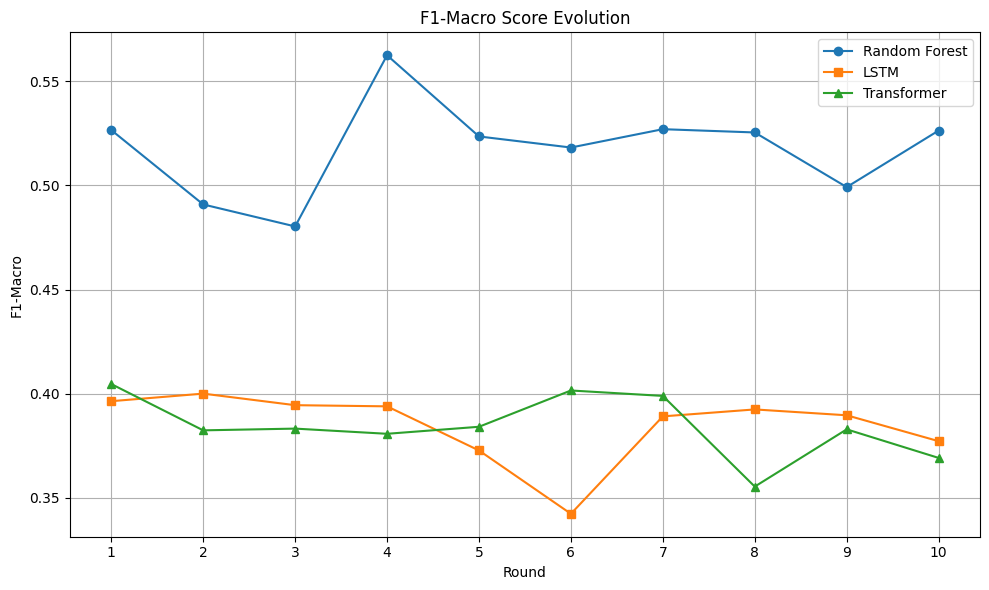

In [48]:
import json
import matplotlib.pyplot as plt
import numpy as np

def visualize_f1_evolution_simple(file_path='models_feature_selection_history.json'):
    with open(file_path, 'r', encoding='utf-8') as f:
        history = json.load(f)

    rounds = np.arange(1, len(history['rf']) + 1)
    
    rf_f1 = [r['metrics']['f1_macro'] for r in history['rf']]
    lstm_f1 = [r['metrics']['f1_macro'] for r in history['lstm']]
    transformer_f1 = [r['metrics']['f1_macro'] for r in history['transformer']]

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, rf_f1, marker='o', label='Random Forest')
    plt.plot(rounds, lstm_f1, marker='s', label='LSTM')
    plt.plot(rounds, transformer_f1, marker='^', label='Transformer')

    plt.title('F1-Macro Score Evolution')
    plt.xlabel('Round')
    plt.ylabel('F1-Macro')
    plt.xticks(rounds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_f1_evolution_simple()


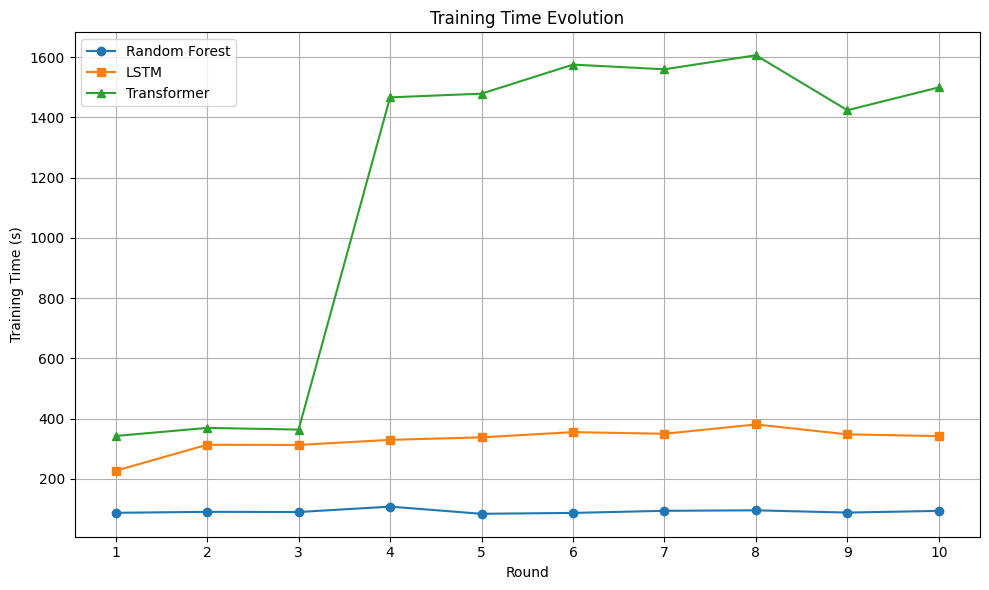

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def visualize_training_time(file_path='models_feature_selection_history.json'):
    with open(file_path, 'r', encoding='utf-8') as f:
        history = json.load(f)

    rounds = np.arange(1, len(history['rf']) + 1)
    
    rf_training_time = [r['metrics']['training_time'] for r in history['rf']]
    lstm_training_time = [r['metrics']['training_time'] for r in history['lstm']]
    transformer_training_time = [r['metrics']['training_time'] for r in history['transformer']]

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, rf_training_time, marker='o', label='Random Forest')
    plt.plot(rounds, lstm_training_time, marker='s', label='LSTM')
    plt.plot(rounds, transformer_training_time, marker='^', label='Transformer')
    
    plt.title('Training Time Evolution')
    plt.xlabel('Round')
    plt.ylabel('Training Time (s)')
    plt.xticks(rounds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_training_time()


In [ ]:
import json

def print_transformer_params(file_path='models_feature_selection_history.json'):
    with open(file_path, 'r', encoding='utf-8') as f:
        history = json.load(f)

    for round_idx, round_data in enumerate(history['transformer'], start=1):
        features = round_data.get('features', [])
        num_features = len(features)
        print(f"Round {round_idx}:")
        print(f" number of features: {num_features}")
        print(f" feature set : {features}")
        print("\n")

print_transformer_params()


Round 1:
 number of features: 19
 feature set : ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_src_ltm', 'trans_depth', 'res_bdy_len', 'ct_flw_http_mthd']


Round 2:
 number of features: 19
 feature set : ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_flw_http_mthd', 'trans_depth', 'res_bdy_len', 'is_sm_ips_ports']


Round 3:
 number of features: 20
 feature set : ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst', 'ct_flw_http_mthd', 'trans_depth', 'res_bdy_len', 'is_sm_ips_ports', 'dttl']


Round 4:
 number of features: 20
 feature set : ['dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl', 'tcprtt', 'synack', 'ackdat', 'ct_srv_

Split the Dataset

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(r"C:\Users\yicheng\Desktop\data\csv\merged_cleaned_dataset.csv")
y = df["attack_cat"]

# construct feature sets based on the best entries
X_rf = df[features_rf]
X_lstm = df[features_lstm]
X_transformer = df[features_transformer]

# Ssplit the data into training and testing sets for each model
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y, test_size=0.2, random_state=42, stratify=y)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)
X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_transformer, y, test_size=0.2, random_state=42, stratify=y)


Split Subsets to Accelerate Model Training

In [37]:
# set the size of the subset for each model
SUBSET_SIZE = 0.2 

X_rf_train_subset, _, y_rf_train_subset, _ = train_test_split(
    X_rf_train, y_rf_train, 
    train_size=SUBSET_SIZE,
    random_state=42, 
    stratify=y_rf_train 
)

X_lstm_train_subset, _, y_lstm_train_subset, _ = train_test_split(
    X_lstm_train, y_lstm_train, 
    train_size=SUBSET_SIZE, 
    random_state=42, 
    stratify=y_lstm_train
)

X_trans_train_subset, _, y_trans_train_subset, _ = train_test_split(
    X_trans_train, y_trans_train, 
    train_size=SUBSET_SIZE, 
    random_state=42, 
    stratify=y_trans_train
)

print(f"raw dataset: {len(X_rf_train)}")
print(f"subset dataset: {len(X_rf_train_subset)}")

raw dataset: 1647534
subset dataset: 329506


Data Preprocessing

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from keras.utils import to_categorical

def preprocess_features(
    df: pd.DataFrame, 
    feature_columns: list,
    add_time_features: bool = False,
    reshape_for_sequence: bool = False,
    fit: bool = True,
    encoder: OneHotEncoder = None,
    scaler: StandardScaler = None,
    numeric_cols: list = None  
):
   
    df = df.copy()
    
    # keep only the specified feature columns
    new_time_features = []
    if 'stime' in df.columns and add_time_features:
        new_time_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
        stime = pd.to_datetime(df['stime'], unit='s', errors='coerce')
        df['hour_sin'] = np.sin(2 * np.pi * stime.dt.hour / 24.0)
        df['hour_cos'] = np.cos(2 * np.pi * stime.dt.hour / 24.0)
        df['day_sin'] = np.sin(2 * np.pi * stime.dt.dayofweek / 7.0)
        df['day_cos'] = np.cos(2 * np.pi * stime.dt.dayofweek / 7.0)
        df.drop(columns='stime', inplace=True)

    # clean feature columns
    cleaned_feature_columns = [col for col in feature_columns if col != 'stime']
    if add_time_features:
        cleaned_feature_columns.extend(new_time_features)

    # seperate categorical and numeric columns
    categorical_cols = df[cleaned_feature_columns].select_dtypes(include=['object']).columns.tolist()
    numeric_cols = df[cleaned_feature_columns].select_dtypes(include=[np.number]).columns.tolist()

    # one-hot encoding
    if fit:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_cat = encoder.fit_transform(df[categorical_cols]) if categorical_cols else np.empty((df.shape[0], 0))
    else:
        X_cat = encoder.transform(df[categorical_cols]) if categorical_cols else np.empty((df.shape[0], 0))
    
    cat_col_names = encoder.get_feature_names_out(categorical_cols) if categorical_cols else []
    df_cat = pd.DataFrame(X_cat, columns=cat_col_names, index=df.index)

    # standard scaling for numeric columns
    if fit:
        numeric_cols = df[cleaned_feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    df_num = df[numeric_cols]  
    if fit:
        scaler = StandardScaler()
        X_num_scaled = scaler.fit_transform(df_num)
    else:
        X_num_scaled = scaler.transform(df_num)
    
    df_num_scaled = pd.DataFrame(X_num_scaled, columns=numeric_cols, index=df.index)

    X_all_array = np.hstack([df_num_scaled.values, df_cat.values])
    # reshape
    if reshape_for_sequence:
        X_all_array = X_all_array.reshape(X_all_array.shape[0], 1, X_all_array.shape[1])  # (samples, timesteps=1, features)

    return X_all_array, encoder, scaler, numeric_cols



def preprocess_labels(y_raw, fit=True, label_encoder=None, to_onehot=True):
    y_arr = np.asarray(y_raw)

    if to_onehot and y_arr.ndim == 2:
        return y_arr, label_encoder  
    
    if y_arr.ndim == 1:
        y_raw = pd.Series(y_arr).reset_index(drop=True)

    if fit or label_encoder is None:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_raw)
    else:
        y_encoded = label_encoder.transform(y_raw)

    if to_onehot:
        y_one_hot = to_categorical(y_encoded)
        return y_one_hot, label_encoder
    else:
        return y_encoded, label_encoder


Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import time

def train_rf_model(X_train_raw, X_test_raw, y_train, y_test, params=None):
    # initialize parameters if not provided
    if params is None:
        params = {
            "n_estimators": 100,
            "max_depth": 20,
            "min_samples_split": 4,
            "min_samples_leaf": 2,  
            "max_features": 5,
            "bootstrap": True
        }

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    # preprocess features
    X_train_processed, encoder, scaler, numeric_cols = preprocess_features(
        df=X_train_raw,
        feature_columns=X_train_raw.columns.tolist(),
        add_time_features=False,
        reshape_for_sequence=False,
        fit=True
    )

    X_test_processed, _, _, _ = preprocess_features(
        df=X_test_raw,
        feature_columns=X_test_raw.columns.tolist(),
        add_time_features=False,
        reshape_for_sequence=False,
        fit=False,
        encoder=encoder,
        scaler=scaler,
        numeric_cols=numeric_cols
    )

    # sampling 
    y_train_series = pd.Series(y_train)
    n_exploits = y_train_series.value_counts().get('Exploits', 100)
    n_normal_new = n_exploits * 3
    under_sampler = RandomUnderSampler(sampling_strategy={'Normal': n_normal_new}, random_state=42)
    over_sample = SMOTE(random_state=42)
    params.pop('class_weight', None)
    pipeline = Pipeline(steps=[
        ('under', under_sampler),
        ('over', over_sample),
        ('clf', RandomForestClassifier(**params, random_state=42))
    ])

    #  model training
    start_time = time.time()
    pipeline.fit(X_train_processed, y_train)
    training_time = time.time() - start_time

    # model prediction
    y_pred = pipeline.predict(X_test_processed)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    base_acc = accuracy_score(y_test, y_pred)
    epoch_metric = [{"accuracy": base_acc, "loss": 1 - base_acc}]

    return {
        "model": "RandomForest",
        "params": params,
        "metrics": {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_macro": f1_score(y_test, y_pred, average='macro'),
            "f1_weighted": f1_score(y_test, y_pred, average='weighted'),
            "classification_report": report_dict
        },
        "training_time": training_time,
        "epoch_metrics": epoch_metric
    }


LSTM

In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf


class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    

def train_lstm_model(X_raw, y_raw, X_test_raw, y_test_raw, params=None):
    default_params = {
        "units": 64,
        "dropout": 0.3,
        "recurrent_dropout": 0.2,
        "epochs": 20,
        "batch_size": 64,
        "gamma": 2.0,
        "alpha": 0.25,
        "learning_rate": 0.001,
        "layers": 1
    }
    if params is None:
        params = default_params
    else:
        for key, value in default_params.items():
            params.setdefault(key, value)

    # label encoding and one-hot encoding
    y_train_encoded, label_encoder = preprocess_labels(y_raw, fit=True, to_onehot=True)
    y_test_encoded, _ = preprocess_labels(y_test_raw, fit=False, label_encoder=label_encoder, to_onehot=True)

    # feature preprocessing
    X_train_processed, encoder, scaler,numeric_cols = preprocess_features(
        df=X_raw,
        feature_columns=X_raw.columns.tolist(),
        add_time_features=True,
        reshape_for_sequence=True,
        fit=True
    )

    X_test_processed, _, _, _ = preprocess_features(
        df=X_test_raw,
        feature_columns=X_test_raw.columns.tolist(),
        add_time_features=True,
        reshape_for_sequence=True,
        fit=False,
        encoder=encoder,
        scaler=scaler,
        numeric_cols=numeric_cols
    )

    # construct the LSTM model
    model = Sequential()
    for i in range(params['layers']):
        return_seq = True if i < params['layers'] - 1 else False 
        
        if i == 0:
            model.add(LSTM(params['units'], 
                           return_sequences=return_seq,
                           recurrent_dropout=params['recurrent_dropout'],
                           input_shape=(X_train_processed.shape[1], X_train_processed.shape[2])))
        else:
            model.add(LSTM(params['units'],
                           return_sequences=return_seq,
                           recurrent_dropout=params['recurrent_dropout']))
                       
        model.add(Dropout(params['dropout']))
    
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])

    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=FocalLoss(gamma=params['gamma'], alpha=params['alpha']),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # train the model
    start_time = time.time()
    history = model.fit(
        X_train_processed, y_train_encoded,
        validation_data=(X_test_processed, y_test_encoded),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1,
        callbacks=[early_stopping]
    )
    training_time = time.time() - start_time

    # predict and evaluate
    y_pred_probs = model.predict(X_test_processed, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_encoded, axis=1)

    report_dict = classification_report(
        y_true, y_pred, target_names=label_encoder.classes_, output_dict=True
    )

    # record epoch metrics
    epoch_metrics = [{"accuracy": acc, "loss": loss}
                     for acc, loss in zip(history.history['val_accuracy'], history.history['val_loss'])]

    return {
        "model": "LSTM",
        "params": params,
        "metrics": {
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average='macro'),
            "f1_weighted": f1_score(y_true, y_pred, average='weighted'),
            "classification_report": report_dict
        },
        "training_time": training_time,
        "epoch_metrics": epoch_metrics
    }


Transformer

In [7]:
import numpy as np
import pandas as pd
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf


def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = K.pow(1 - y_pred, gamma)
        if alpha is not None:
            alpha_tensor = K.constant(alpha, dtype=y_pred.dtype)
            weight *= alpha_tensor
        return K.mean(K.sum(weight * cross_entropy, axis=-1))
    return loss_fn


def train_transformer_model(X_raw, y_raw, X_test_raw, y_test_raw, params=None):
    default_params = {
        "num_heads": 2,
        "ff_dim": 64,
        "num_layers": 1,
        "dropout_rate": 0.3,
        "epochs": 20,
        "activation": 'relu',
        "learning_rate": 0.001,
        "batch_size": 64,
        "gamma": 2.0,
        "alpha": 0.25
    }
    if params is None:
        params = default_params.copy()
    else:
        for key, value in default_params.items():
            params.setdefault(key, value)

    # label encoding and one-hot encoding
    y_train_encoded, label_encoder = preprocess_labels(y_raw, fit=True, to_onehot=True)
    y_test_encoded, _ = preprocess_labels(y_test_raw, fit=False, label_encoder=label_encoder, to_onehot=True)

    # feature preprocessing
    X_train_seq, encoder, scaler, numeric_cols = preprocess_features(
        df=X_raw,
        feature_columns=X_raw.columns.tolist(),
        add_time_features=True,
        reshape_for_sequence=True,
        fit=True
    )

    X_test_seq, _, _, _ = preprocess_features(
        df=X_test_raw,
        feature_columns=X_test_raw.columns.tolist(),
        add_time_features=True,
        reshape_for_sequence=True,
        fit=False,
        encoder=encoder,
        scaler=scaler,
        numeric_cols=numeric_cols
    )

    class_indices = np.argmax(y_train_encoded, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_indices), y=class_indices)
    alpha = class_weights / np.sum(class_weights)

    # construct the Transformer model
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2]) 
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(params["num_layers"]):
        # Multi-head Attention Block
        timesteps,features = input_shape
        attn_output = MultiHeadAttention(num_heads=params["num_heads"], key_dim=features//params["num_heads"])(x, x)
        attn_output = Dropout(params["dropout_rate"])(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feedforward Block
        ff_output = Dense(params["ff_dim"], activation=params["activation"])(x)
        ff_output = Dense(input_shape[1])(ff_output)  
        ff_output = Dropout(params["dropout_rate"])(ff_output)
        x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(params["dropout_rate"])(x)
    outputs = Dense(y_train_encoded.shape[1], activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss=focal_loss(gamma=params['gamma'], alpha=alpha),
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # train the model
    start_time = time.time()
    history = model.fit(
        X_train_seq, y_train_encoded,
        validation_data=(X_test_seq, y_test_encoded),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1,
        callbacks=[early_stop]
    )
    training_time = time.time() - start_time

    # predict and evaluate
    y_pred_probs = model.predict(X_test_seq, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_encoded, axis=1)

    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
 
    # record epoch metrics
    epoch_metrics = [{"accuracy": acc, "loss": loss}
                     for acc, loss in zip(history.history['val_accuracy'], history.history['val_loss'])]

    return {
        "model": "Transformer",
        "params": params,
        "metrics": {
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average='macro'),
            "f1_weighted": f1_score(y_true, y_pred, average='weighted'),
            "classification_report": report
        },
        "training_time": training_time,
        "epoch_metrics": epoch_metrics
    }


Tune Hyperparameter by OpenAI

In [22]:
import openai
import json
from dotenv import load_dotenv

load_dotenv()  
openai.api_key = os.getenv("openai_key")
# record the history of model parameters and results
history_memory = {
    "RandomForest": [],
    "LSTM": [],
    "Transformer": []
}

def param_improve(model_name, metrics, old_params, classification_report=None, round_id=None, history=None, training_time=None):
   
    # add the new entry to the history memory
    history_memory[model_name].append({
        "model_name": model_name,
        "round": len(history_memory[model_name]) + 1,
        "params": old_params,
        "metrics": metrics,
        "classification_report": classification_report,
        "training_time": training_time
    })
    
    full_history_str = ""
    for h in history_memory[model_name]:
        key_metrics = {
            "accuracy": h['metrics'].get('accuracy'),
            "macro F1": h['metrics'].get('macro F1'),
            "weighted F1": h['metrics'].get('weighted F1'),
            "macro recall": h['metrics'].get('macro rec'),
            "macro precision": h['metrics'].get('macro prec')
        }
        full_history_str += (
            f"Round {h['round']}:\n"
            f"  Parameters: {json.dumps(h['params'])}\n"
            f"  Key Metrics: {json.dumps(key_metrics)}\n"
            f"  Training Time: {h['training_time']:.0f}s\n\n" if h.get('training_time') is not None else ""
        )
    
    system_prompt = f"""
You are an advanced machine learning assistant specializing in optimizing models for Network Intrusion Detection Systems (NIDS).

You will work on a multi-class classification task using the UNSW-NB15 dataset to detect abnormal network behaviors. Please note that this dataset is highly imbalanced, so you must not focus solely on the performance of majority classes.
And your primary goal is to maximize the 'macro F1' score because of the imbalanced dataset. In this case, 'macro F1' best reflects the model's performance across all classes, including rare attack types. All other metrics are secondary.

The models in use include Random Forest, LSTM, and Transformer. 
I will provide you with:
- The model type; 
- The current set of hyperparameters; 
- The evaluation metrics from each training round (e.g., accuracy, classification report, F1-score, etc.).

You should leverage your knowledge of:
- The strengths and use cases of Random Forest, LSTM, and Transformer in NIDS;
- How metrics such as precision, recall, and F1-score affect hyperparameter tuning;
- Common hyperparameter adjustment strategies for models (e.g., n_estimators, dropout, learning_rate, num_heads, etc.).
- Evaluate class-wise metrics (especially F1-score and recall) to detect per-class degradation or improvement.

Guiding principles and suggested ranges for parameters:
Your role is to act as an expert, please use the following principles and suggested ranges as a starting point, but you have the authority to propose values outside these ranges if your analysis of the history strongly indicates it's a necessary and logical step for exploration.
For RandomForest:
- n_estimators:
  - Principle: A positive integer, representing the number of trees.
  - Suggested Range: A good starting range for exploration is between 100 and 300.
  - Freedom to Explore: If performance stagnates, you may propose a significantly larger value (e.g., 500) to see if a more complex model helps, but justify the potential increase in training time.
- max_depth:
  - Principle: A positive integer or `null` (for no limit). Deeper trees can overfit.
  - Suggested Range: Explore between 20 and 50.
  - Freedom to Explore: You can try smaller values (e.g., 10) to combat overfitting, or `null` if you hypothesize the feature interactions are very complex.

For LSTM / Transformer:
- num_layers:
  - Principle: A positive integer (e.g., 1, 2, 3...). More layers increase complexity and risk of overfitting.
  - Suggested Range: It's wise to explore in the range of [1, 6].
  - Freedom to Explore: Only propose deeper models (e.g., 8 layers) if simpler models have clearly hit a performance ceiling and you justify the need for higher capacity.
- dropout_rate:
  - Principle: A float between 0.0 and 1.0. This is a key regularization parameter.
  - Suggested Range: Most effective values are often found between 0.1 and 0.5.
  - Freedom to Explore: If severe overfitting is observed (high training accuracy, low validation accuracy/macro F1), you are encouraged to propose higher values like 0.6 or even 0.7, justifying it as a strong regularization attempt.
- learning_rate:
  - Principle: A small positive float. This is a critical parameter.
  - Suggested Range: The most common effective range is between 1e-4 (0.0001) and 2e-3 (0.002).
  - Freedom to Explore: You can suggest values outside this range, but this should be a deliberate choice. For example, a much smaller learning rate (e.g., 5e-5) can be used for fine-tuning a good model, while a slightly larger one might help escape a local minimum. Justify your choice clearly.
- batch_size:
  - Principle: A positive integer, typically a power of 2 (e.g., 32, 64, 128).
  - Suggested Range: [32, 64, 128] is a standard and safe range.
  - Freedom to Explore: You can propose larger batch sizes (e.g., 256) which can speed up training but may lead to poorer generalization. This trade-off must be mentioned in your thinking.

Expert Heuristics and Strategies:
You must use these expert strategies to guide your decisions, especially for LSTM and Transformer.
For All Models:
- **Heuristic #0 (Baseline Logic)**: If a parameter change in the last round resulted in a better 'macro F1', continue exploring in that direction (e.g., slightly increase it again). If it resulted in a worse score, revert the change and try a different parameter.

For Deep Learning Models (LSTM & Transformer):
These models are sensitive. Follow these rules strictly to ensure improvement:
- **Heuristic #1 (Learning Rate is King)**: The learning rate is the most critical parameter.
  - If performance is poor or stagnating**: Try a slightly LARGER learning rate (e.g., from 0.0005 to 0.001) to encourage faster convergence or escape a local optimum.
  - If performance improves but is unstable, or if you suspect overfitting**: Try a SMALLER learning rate (e.g., from 0.001 to 0.0005) for more stable, fine-grained tuning.

- **Heuristic #2 (Start Simple, Grow Smart)**: Always begin with a simpler architecture.
  - Do NOT increase `num_layers` or `units`/`ff_dim` unless the `macro F1` score has clearly stopped improving for at least one round with simpler models.
  - When you do increase complexity, do it incrementally (e.g., `num_layers` from 2 to 3, not 2 to 4).

- **Heuristic #3 (Targeted Regularization)**: Use `dropout` to fight overfitting, not as a random guess.
  - **Definition of Overfitting**: A high `weighted F1` (meaning it learns the 'Normal' class well) but a low `macro F1` (meaning it fails on attack classes) is a strong sign of overfitting.
  - **Action**: If you observe this pattern, your immediate next step should be to INCREASE the `dropout_rate` (e.g., from 0.3 to 0.4).

- **Heuristic #4 (The 'Stuck' Protocol)**: If the `macro F1` score fails to improve for two consecutive rounds despite small changes:
  - Propose a **bold but logical** change. For example: "The model seems stuck. Applying Heuristic #4, I will now test a much larger model by increasing 'units' from 64 to 128 to see if model capacity is the bottleneck." OR "I will try a different, more complex feature like 'ct_srv_dst' which might provide new information." (This last part is an advanced suggestion for you, showing the Agent can even suggest feature changes).

- **Heuristic #5 (Control Variables - HIGHEST PRIORITY): You MUST only change one major hyperparameter (num_layers, ff_dim, learning_rate) at a time. 
  - You can make a small adjustment to a secondary parameter (like dropout_rate) alongside a major change, but you must justify it. For example: "I am increasing num_layers to 3, and as a precaution against overfitting, I am also increasing dropout_rate slightly to 0.35."

For each new suggestion, you MUST follow this step-by-step reasoning process:
1.  Analyze History: Briefly review the historical data. What was the trend of 'macro F1'? Which parameter changes led to improvements or degradations?
2.  Formulate Hypothesis: Based on the analysis, state a clear hypothesis. For example: "The 'macro recall' is high but 'macro precision' is low, suggesting the model is too aggressive and overfitting. My hypothesis is that increasing regularization will improve 'macro F1'." OR "The 'macro F1' has plateaued. My hypothesis is that a significant change in model architecture, like increasing depth, is needed to find a better optimum."
3.  Propose Concrete Changes: Translate your hypothesis into specific parameter changes based on the allowed search space below. For example: "To test my hypothesis, I will increase the 'dropout_rate' from 0.2 to 0.4."
4.  Justify Your Proposal: Briefly explain why your proposed changes are expected to increase the 'macro F1' score.

Your suggestions must also consider runtime efficiency: avoid increasing training time excessively if the results do not improve significantly.
You must consider all history trends, not just the last result. If a change leads to a significant drop in 'macro F1', your very next proposal MUST start from the parameters of the previous best-performing round, not the failed one. You must explicitly state this reversion in your 'thinking' process.

Output Format
You MUST return ONLY a single valid JSON object. This object must contain two keys:
1.  `"thinking"`: A string containing your step-by-step reasoning (Analyze, Hypothesize, Propose, Justify).
2.  `"params"`: A JSON dictionary containing the new hyperparameter suggestions.

Example for Transformer:
{{
  "thinking": "Analysis: The macro F1 increased in Round 2 but then dropped in Round 3 when I increased the learning rate. Hypothesis: The previous learning rate was too high, causing instability. I will now reduce the learning rate and increase model complexity to better capture features. Proposal: Decrease learning_rate to 0.0003 and increase num_layers to 4. Justification: This should lead to more stable training and a model with higher capacity, improving macro F1.",
  "params": {{"num_layers": 4,"ff_dim": 256,"num_heads": 8,"dropout_rate": 0.3,"learning_rate": 0.0003,
  "batch_size": 64,"epochs": 15,"activation": "relu","gamma": 2,"alpha": 0.25}}
}}
"""

    user_prompt = f"""
type of model：{model_name}

history of hyperparameters and performance metrics:
{full_history_str}
    
Please give new suggested parameters in JSON format based on the above information.
"""

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.5,
            response_format={"type": "json_object"}
        )
        reply = response['choices'][0]['message']['content']

        new_data = json.loads(reply)
        thinking_process = new_data.get("thinking", "No reasoning provided.")
        new_params = new_data.get("params", old_params)
        print(f"Reasoning for [{model_name}]")
        print(thinking_process)
        print(f"[{model_name}] suggested new parameters:", new_params)
        return new_params

    except Exception as e:
        print(f"[{model_name}] Parameter optimization failed:", e)
        return old_params



main

In [ ]:
def rf_training(X_rf_train, X_rf_test, y_rf_train, y_rf_test, n_rounds):

    from copy import deepcopy

    results = {"RandomForest": []}

    # initial parameters for RF
    param_rf = {"n_estimators": 100,"max_depth": 20,"min_samples_split": 4,"min_samples_leaf": 2,"max_features": 5}
    
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # Random Forest
        print("Training Random Forest...")
        rf_result = train_rf_model(X_rf_train.copy(), X_rf_test.copy(), y_rf_train.copy(), y_rf_test.copy(), deepcopy(param_rf))
        results['RandomForest'].append(rf_result)
        param_rf = param_improve("RandomForest", rf_result["metrics"], param_rf, rf_result.get("classification_report"), round_id=round_i + 1, history=results["RandomForest"], training_time=rf_result.get("training_time"))
        
        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['RandomForest'],
                                  [rf_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print(" Training Random Forest...")
    final_rf_result = train_rf_model(X_rf_train.copy(), X_rf_test.copy(), y_rf_train.copy(), y_rf_test.copy(), deepcopy(param_rf))
    results['RandomForest'].append(final_rf_result)

    # final result
    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['RandomForest'],
                                  [final_rf_result]):
        print(f" {model_name} Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")

    
    try:        
        filename = f"RandomForest_Results.txt"
        with open(filename, 'w', encoding='utf-8') as f:            
            # output the results
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}")

                # record hyperparameters and metrics
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")    
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                # detailed classification report
                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else:
                        f.write(f"{label:15} | {metrics:.4f}\n")
                
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")

    except Exception as e:
        print(f"\n Failed: {e}")

    return results

results = rf_training(X_rf_train_subset, X_rf_test, y_rf_train_subset, y_rf_test, n_rounds=10)


In [ ]:
def lstm_training(X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test, n_rounds):
    from copy import deepcopy
    results = {"LSTM": []}

    # initial parameters for LSTM
    param_lstm = {"units": 64,"dropout": 0.3,"recurrent_dropout": 0.2,"epochs": 20,"batch_size": 64,
                  "gamma": 2.0,"alpha": 0.25,"learning_rate": 0.001,"layers": 1}
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # LSTM
        print("Training LSTM...")
        lstm_result = train_lstm_model(X_lstm_train.copy(), y_lstm_train.copy(), X_lstm_test.copy(), y_lstm_test.copy(), deepcopy(param_lstm))
        results['LSTM'].append(lstm_result)
        param_lstm = param_improve("LSTM", lstm_result["metrics"], param_lstm, lstm_result['metrics'].get("classification_report"), round_i + 1, results["LSTM"], lstm_result.get("training_time"))

        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['LSTM'],
                                  [lstm_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print("Training LSTM...")
    final_lstm_result = train_lstm_model(X_lstm_train.copy(), y_lstm_train.copy(), X_lstm_test.copy(), y_lstm_test.copy(), deepcopy(param_lstm))
    results['LSTM'].append(final_lstm_result)

    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['LSTM'],
                                  [final_lstm_result]):
        print(f" {model_name} Final Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")
    try:        
        filename = f"LSTM_Results.txt"
        with open(filename, 'w', encoding='utf-8') as f:            
            
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}\n")
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                # detailed classification report
                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else: 
                        f.write(f"{label:15} | {metrics:.4f}\n")
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")
    except Exception as e:
        print(f"\n Failed: {e}")

    return results

results = lstm_training(X_lstm_train_subset, X_lstm_test, y_lstm_train_subset, y_lstm_test,n_rounds=10)



 Round 1 / 11
Training LSTM...
Epoch 1/20


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9434 - loss: 0.0493 - val_accuracy: 0.9708 - val_loss: 0.0130
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9698 - loss: 0.0134 - val_accuracy: 0.9720 - val_loss: 0.0121
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9710 - loss: 0.0124 - val_accuracy: 0.9727 - val_loss: 0.0114
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9714 - loss: 0.0119 - val_accuracy: 0.9730 - val_loss: 0.0112
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9722 - loss: 0.0116 - val_accuracy: 0.9734 - val_loss: 0.0110
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9727 - loss: 0.0113 - val_accuracy: 0.9734 - val_loss: 0.0108
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9723 - loss: 0.0114 - val_accuracy: 0.9740 - val_loss: 0.0106
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9724 - loss: 0.0112 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Across the three rounds, the accuracy has slightly decreased, but more importantly, the 'macro F1' is consistently null, indicating that it hasn't been properly evaluated or reported. This suggests a potential issue with evaluation setup rather than model performance. Hypothesis: Assuming the 'macro F1' is low due to potential overfitting or underfitting, I will adjust the model to encourage better generalization and performance on minority classes. Proposal: Increase the number of layers to 2 to allow the model to learn more complex patterns, and slightly increase dropout to 0.4 to prevent overfitting. Justification: Increasing layers can help capture more complex interactions, while increasing dropout will help regularize the model, potentially improving the 'macro F1' once it's correctly evaluated.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learn

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - accuracy: 0.9543 - loss: 0.0434 - val_accuracy: 0.9704 - val_loss: 0.0130
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9690 - loss: 0.0137 - val_accuracy: 0.9715 - val_loss: 0.0120
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9705 - loss: 0.0126 - val_accuracy: 0.9729 - val_loss: 0.0112
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9713 - loss: 0.0119 - val_accuracy: 0.9727 - val_loss: 0.0109
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9718 - loss: 0.0116 - val_accuracy: 0.9735 - val_loss: 0.0105
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9719 - loss: 0.0112 - val_accuracy: 0.9731 - val_loss: 0.0105
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9728 - loss: 0.0108 - val_accuracy: 0.9736 - val_loss: 0.0102
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9728 - loss: 0.01

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 score has not been reported in any round, which is crucial for evaluating the model's performance on this imbalanced dataset. However, the accuracy has remained relatively stable with a slight improvement in Round 4 after increasing the number of layers and dropout rate. Hypothesis: The lack of macro F1 data suggests a focus on accuracy, which may not reflect true performance. Increasing model complexity in Round 4 seemed to help slightly, indicating a potential need for more capacity. Proposal: Increase the number of layers to 3 and maintain the dropout rate to further explore model complexity. Justification: Adding another layer should allow the model to capture more complex patterns, which is necessary given the imbalanced nature of the dataset. This should help improve the macro F1 score once it is properly recorded.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'g

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 111s 19ms/step - accuracy: 0.9584 - loss: 0.0432 - val_accuracy: 0.9692 - val_loss: 0.0142
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 96s 19ms/step - accuracy: 0.9685 - loss: 0.0144 - val_accuracy: 0.9711 - val_loss: 0.0125
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 98s 19ms/step - accuracy: 0.9704 - loss: 0.0131 - val_accuracy: 0.9727 - val_loss: 0.0115
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 97s 19ms/step - accuracy: 0.9712 - loss: 0.0122 - val_accuracy: 0.9715 - val_loss: 0.0111
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 99s 19ms/step - accuracy: 0.9709 - loss: 0.0119 - val_accuracy: 0.9731 - val_loss: 0.0111
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 98s 19ms/step - accuracy: 0.9718 - loss: 0.0114 - val_accuracy: 0.9731 - val_loss: 0.0106
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 100s 19ms/step - accuracy: 0.9721 - loss: 0.0113 - val_accuracy: 0.9729 - val_loss: 0.0104
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 100s 19ms/step - accuracy: 0.9720 - loss: 0

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Over the rounds, the accuracy has remained fairly stable, with slight improvements when increasing the number of layers from 1 to 3 and dropout from 0.3 to 0.4. However, 'macro F1' and other metrics have not been reported, which suggests a focus on accuracy might be misleading given the imbalanced nature of the dataset. Hypothesis: The model might be overfitting the majority class due to high accuracy but no improvement in 'macro F1'. Increasing the dropout rate further could help regularize the model. Proposal: Increase dropout to 0.5 and slightly decrease the learning rate to 0.0005 to stabilize training and encourage better generalization across classes. Justification: This should help reduce overfitting and improve 'macro F1' by focusing on underrepresented classes.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.5, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.0005, 'layers': 3}


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9522 - loss: 0.0591 - val_accuracy: 0.9685 - val_loss: 0.0148
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.9675 - loss: 0.0156 - val_accuracy: 0.9700 - val_loss: 0.0138
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.9683 - loss: 0.0148 - val_accuracy: 0.9710 - val_loss: 0.0130
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.9692 - loss: 0.0141 - val_accuracy: 0.9719 - val_loss: 0.0123
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 96s 19ms/step - accuracy: 0.9702 - loss: 0.0131 - val_accuracy: 0.9724 - val_loss: 0.0117
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 98s 19ms/step - accuracy: 0.9707 - loss: 0.0128 - val_accuracy: 0.9726 - val_loss: 0.0114
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 100s 19ms/step - accuracy: 0.9704 - loss: 0.0127 - val_accuracy: 0.9726 - val_loss: 0.0111
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 98s 19ms/step - accuracy: 0.9709 - loss: 0.0

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 score is not available, which is critical for tuning. However, the accuracy slightly increased with more layers and higher dropout, indicating potential overfitting was being addressed. The drop in accuracy in Round 6 suggests that the learning rate reduction to 0.0005 did not help, possibly due to insufficient learning capacity with the current architecture. Hypothesis: The model might benefit from increased complexity to better capture the data's nuances, as the accuracy has plateaued. Proposal: Increase the number of layers to 4 and adjust the learning rate back to 0.001 to give the model more capacity and learning power. Also, maintain dropout at 0.5 to continue addressing overfitting. Justification: This should help the model learn more complex patterns while maintaining regularization to prevent overfitting, potentially improving macro F1 once calculated.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.5, 'recurrent_dropout'

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 130s 24ms/step - accuracy: 0.9527 - loss: 0.0451 - val_accuracy: 0.9678 - val_loss: 0.0152
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 0.9664 - loss: 0.0160 - val_accuracy: 0.9705 - val_loss: 0.0137
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 130s 25ms/step - accuracy: 0.9684 - loss: 0.0145 - val_accuracy: 0.9714 - val_loss: 0.0125
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 127s 25ms/step - accuracy: 0.9696 - loss: 0.0135 - val_accuracy: 0.9712 - val_loss: 0.0118
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 131s 25ms/step - accuracy: 0.9701 - loss: 0.0131 - val_accuracy: 0.9705 - val_loss: 0.0119
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 130s 25ms/step - accuracy: 0.9707 - loss: 0.0127 - val_accuracy: 0.9727 - val_loss: 0.0113
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 129s 25ms/step - accuracy: 0.9711 - loss: 0.0122 - val_accuracy: 0.9724 - val_loss: 0.0112
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 130s 25ms/step - accuracy: 0.9708 - lo

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 score has not been reported, which is critical for evaluating model performance on this imbalanced dataset. However, examining the trend, accuracy peaked in Round 5 with 3 layers and a dropout of 0.4, but dropped when the learning rate was reduced in Round 6 and when layers increased in Round 7. Hypothesis: The model's performance may be suffering from overfitting due to increased complexity without significant gains from deeper layers. Proposal: I will revert to the parameters from Round 5 but increase dropout to 0.5 to combat potential overfitting while maintaining 3 layers. Justification: This should provide a balance between model complexity and regularization, potentially improving macro F1 by stabilizing training.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.5, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.001, 'layers': 3}

 Round 5 Results Summary:
------------

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - accuracy: 0.9583 - loss: 0.0443 - val_accuracy: 0.9691 - val_loss: 0.0142
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.9683 - loss: 0.0148 - val_accuracy: 0.9714 - val_loss: 0.0126
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.9692 - loss: 0.0136 - val_accuracy: 0.9723 - val_loss: 0.0118
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.9705 - loss: 0.0129 - val_accuracy: 0.9726 - val_loss: 0.0112
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - accuracy: 0.9700 - loss: 0.0126 - val_accuracy: 0.9731 - val_loss: 0.0111
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.9713 - loss: 0.0120 - val_accuracy: 0.9726 - val_loss: 0.0108
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.9713 - loss: 0.0119 - val_accuracy: 0.9729 - val_loss: 0.0108
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.9715 -

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 scores are missing, but the accuracy trends suggest that increasing complexity (layers) and dropout initially improved performance (Rounds 4 and 5). However, further increases in complexity and dropout (Rounds 6 and 7) led to a decline in accuracy, possibly indicating overfitting or instability. In Round 8, reverting to 3 layers with a learning rate of 0.001 showed slight improvement over Round 6 but not as high as Round 5. Hypothesis: The learning rate might be too high for the current model complexity, leading to instability. Reducing it could stabilize training and improve macro F1. Proposal: Decrease learning_rate to 0.0005 and retain layers at 3 with a slight reduction in dropout to 0.4 for better regularization balance. Justification: A smaller learning rate should allow for more stable convergence, while moderate dropout should help prevent overfitting, potentially improving macro F1.
[LSTM] suggested new parameters: {'units': 64, 'dro

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - accuracy: 0.9537 - loss: 0.0578 - val_accuracy: 0.9691 - val_loss: 0.0145
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.9673 - loss: 0.0155 - val_accuracy: 0.9694 - val_loss: 0.0135
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 86s 17ms/step - accuracy: 0.9690 - loss: 0.0141 - val_accuracy: 0.9713 - val_loss: 0.0126
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.9701 - loss: 0.0134 - val_accuracy: 0.9716 - val_loss: 0.0119
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 86s 17ms/step - accuracy: 0.9706 - loss: 0.0126 - val_accuracy: 0.9725 - val_loss: 0.0113
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.9712 - loss: 0.0122 - val_accuracy: 0.9728 - val_loss: 0.0111
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 119s 23ms/step - accuracy: 0.9715 - loss: 0.0118 - val_accuracy: 0.9730 - val_loss: 0.0110
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 108s 21ms/step - accuracy: 0.9712 - loss: 0.

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Across rounds, the accuracy has been relatively stable, but we lack 'macro F1' data, making it difficult to assess performance on minority classes. Recent rounds with increased dropout and learning rate adjustments have not shown significant improvements in accuracy. Hypothesis: The model might be too complex or over-regularized, leading to diminished performance. Reducing dropout could help increase model capacity without adding layers. Proposal: Decrease dropout to 0.3, maintain recurrent_dropout at 0.2, and revert to a learning rate of 0.001 to balance stability and learning rate. Justification: This should provide a more stable training process and potentially improve the model's ability to learn from minority classes, thereby improving macro F1.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.3, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.001, 'layers': 3}

 Round 7 Results Sum

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 87s 16ms/step - accuracy: 0.9578 - loss: 0.0424 - val_accuracy: 0.9711 - val_loss: 0.0131
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.9694 - loss: 0.0136 - val_accuracy: 0.9725 - val_loss: 0.0115
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.9711 - loss: 0.0122 - val_accuracy: 0.9730 - val_loss: 0.0109
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.9716 - loss: 0.0118 - val_accuracy: 0.9737 - val_loss: 0.0108
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.9727 - loss: 0.0111 - val_accuracy: 0.9738 - val_loss: 0.0103
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.9723 - loss: 0.0112 - val_accuracy: 0.9738 - val_loss: 0.0102
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.9728 - loss: 0.0105 - val_accuracy: 0.9744 - val_loss: 0.0099
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.9732 - loss: 0.01

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 is consistently null, indicating possible issues in evaluation setup or data collection. Accuracy is high but not improving significantly, suggesting a potential lack of model capacity or overfitting. In Round 5, increasing layers to 3 with dropout 0.4 slightly improved accuracy. However, further increases in layers or dropout did not help, and a lower learning rate in Round 6 decreased accuracy. Hypothesis: The model might benefit from a slightly more complex architecture to capture the nuances of the imbalanced classes, while maintaining regularization to prevent overfitting. Proposal: I will increase the number of units to 128 to enhance model capacity and revert to a dropout rate of 0.4 to balance complexity and regularization. Justification: Increasing units should allow the model to learn more complex patterns, potentially improving macro F1 when properly evaluated. Maintaining dropout at 0.4 should help control overfitting without redu

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 293s 56ms/step - accuracy: 0.9612 - loss: 0.0356 - val_accuracy: 0.9700 - val_loss: 0.0127
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 373s 73ms/step - accuracy: 0.9687 - loss: 0.0130 - val_accuracy: 0.9730 - val_loss: 0.0111
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 373s 72ms/step - accuracy: 0.9711 - loss: 0.0119 - val_accuracy: 0.9729 - val_loss: 0.0106
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 383s 74ms/step - accuracy: 0.9713 - loss: 0.0113 - val_accuracy: 0.9727 - val_loss: 0.0102
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 371s 72ms/step - accuracy: 0.9719 - loss: 0.0110 - val_accuracy: 0.9740 - val_loss: 0.0100
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 332s 64ms/step - accuracy: 0.9730 - loss: 0.0105 - val_accuracy: 0.9735 - val_loss: 0.0099
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 347s 67ms/step - accuracy: 0.9728 - loss: 0.0107 - val_accuracy: 0.9744 - val_loss: 0.0098
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 370s 72ms/step - accuracy: 0.9730 - lo

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The 'macro F1' scores are not provided, making it challenging to assess class-wise performance improvements. However, accuracy trends show some improvement when increasing complexity (e.g., units and layers), but a drop in accuracy when the dropout was increased too much. Hypothesis: The model may benefit from a slightly larger learning rate to escape potential local minima and improve convergence, as the recent changes in complexity have not led to significant improvements. Proposal: Increase the learning rate slightly from 0.001 to 0.0015 to encourage faster learning and potential escape from local minima. Justification: A slightly larger learning rate should help improve convergence speed and possibly lead to better overall performance, including 'macro F1', which is our target metric.
[LSTM] suggested new parameters: {'units': 128, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 383s 73ms/step - accuracy: 0.9606 - loss: 0.0314 - val_accuracy: 0.9701 - val_loss: 0.0126
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 644s 125ms/step - accuracy: 0.9698 - loss: 0.0129 - val_accuracy: 0.9725 - val_loss: 0.0110
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 206s 40ms/step - accuracy: 0.9717 - loss: 0.0116 - val_accuracy: 0.9725 - val_loss: 0.0105
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 223s 43ms/step - accuracy: 0.9715 - loss: 0.0113 - val_accuracy: 0.9733 - val_loss: 0.0102
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - accuracy: 0.9723 - loss: 0.0108 - val_accuracy: 0.9739 - val_loss: 0.0101
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 227s 44ms/step - accuracy: 0.9726 - loss: 0.0108 - val_accuracy: 0.9734 - val_loss: 0.0100
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 214s 41ms/step - accuracy: 0.9723 - loss: 0.0106 - val_accuracy: 0.9746 - val_loss: 0.0098
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 220s 43ms/step - accuracy:

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 is not provided, but observing the accuracy trends, it seems that the model's performance has plateaued. The best accuracy was observed in Round 11 after increasing units to 128, but the learning rate increase in Round 12 led to a slight decrease in accuracy. Hypothesis: The model might benefit from a more stable learning process. My hypothesis is that reducing the learning rate will provide more stable training and potentially improve macro F1. Proposal: Decrease learning_rate to 0.0005. Justification: This should allow for finer adjustments during training, potentially improving macro F1 by better capturing the minority classes without overfitting.
[LSTM] suggested new parameters: {'units': 128, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.0005, 'layers': 3}

 Round 10 Results Summary:
------------------------------------------------------------
 LSTM Classificatio

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 246s 47ms/step - accuracy: 0.9563 - loss: 0.0482 - val_accuracy: 0.9687 - val_loss: 0.0140
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 245s 47ms/step - accuracy: 0.9686 - loss: 0.0141 - val_accuracy: 0.9713 - val_loss: 0.0122
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 246s 48ms/step - accuracy: 0.9703 - loss: 0.0127 - val_accuracy: 0.9725 - val_loss: 0.0114
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 248s 48ms/step - accuracy: 0.9713 - loss: 0.0121 - val_accuracy: 0.9729 - val_loss: 0.0110
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 263s 48ms/step - accuracy: 0.9716 - loss: 0.0116 - val_accuracy: 0.9741 - val_loss: 0.0107
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 243s 47ms/step - accuracy: 0.9721 - loss: 0.0113 - val_accuracy: 0.9739 - val_loss: 0.0103
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 242s 47ms/step - accuracy: 0.9725 - loss: 0.0110 - val_accuracy: 0.9746 - val_loss: 0.0101
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 253s 49ms/step - accuracy: 0.9732 - lo

In [ ]:
def transformer_training(X_trans_train, X_trans_test, y_trans_train, y_trans_test, n_rounds):
    from copy import deepcopy
    results = {"Transformer": []}

    # initial parameters for Transformer
    param_transformer = {
        "num_heads": 2,
        "ff_dim": 64,
        "num_layers": 1,
        "dropout_rate": 0.3,
        "epochs": 20,
        "activation": 'relu',
        "learning_rate": 0.001,
        "batch_size": 64,
        "gamma": 2.0,
        "alpha": 0.25
    }
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # Transformer
        print("Training Transformer...")
        transformer_result = train_transformer_model(X_trans_train.copy(), y_trans_train.copy(), X_trans_test.copy(), y_trans_test.copy(), deepcopy(param_transformer))
        results['Transformer'].append(transformer_result)
        param_transformer = param_improve("Transformer", transformer_result["metrics"], param_transformer, transformer_result['metrics'].get("classification_report"), round_i + 1, results["Transformer"], transformer_result.get("training_time"))

        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['Transformer'],
                                  [transformer_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print("Training Transformer...")
    final_transformer_result = train_transformer_model(X_trans_train.copy(), y_trans_train.copy(), X_trans_test.copy(), y_trans_test.copy(), deepcopy(param_transformer))
    results['Transformer'].append(final_transformer_result)

    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['Transformer'],
                                  [final_transformer_result]):
        print(f" {model_name} Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")

    # save results            
    try:        
        filename = f"Transformer_Results.txt"
        with open(filename, 'w', encoding='utf-8') as f:        
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}\n")
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else: 
                        f.write(f"{label:15} | {metrics:.4f}\n")
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")
    except Exception as e:
        print(f"\n Failed: {e}")
    return results

results = transformer_training(X_trans_train_subset, X_trans_test, y_trans_train_subset, y_trans_test, n_rounds=10)



 Round 1 / 11
Training Transformer...
Epoch 1/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.7955 - loss: 9.2260e-04 - val_accuracy: 0.9431 - val_loss: 6.3637e-04
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9218 - loss: 6.3615e-04 - val_accuracy: 0.9554 - val_loss: 5.6764e-04
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9354 - loss: 6.1094e-04 - val_accuracy: 0.9593 - val_loss: 5.4733e-04
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9425 - loss: 5.9523e-04 - val_accuracy: 0.9551 - val_loss: 5.3128e-04
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9454 - loss: 5.9722e-04 - val_accuracy: 0.9591 - val_loss: 5.1313e-04
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9460 - loss: 5.6484e-04 - val_accuracy: 0.9563 - val_loss: 5.2429e-04
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9470 - loss: 5.4937e-04 - val_accuracy: 0.9623 - val_loss:

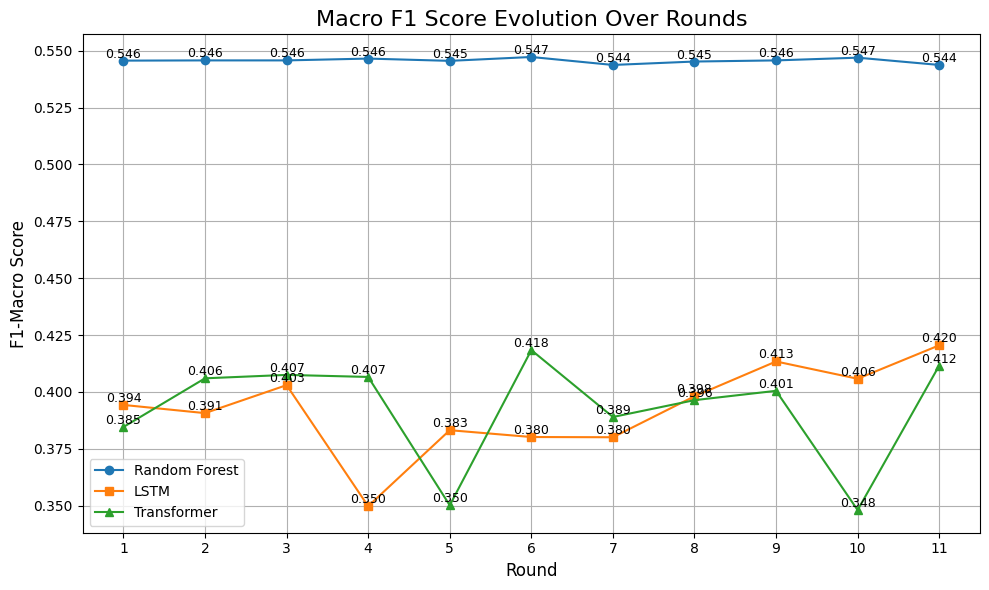

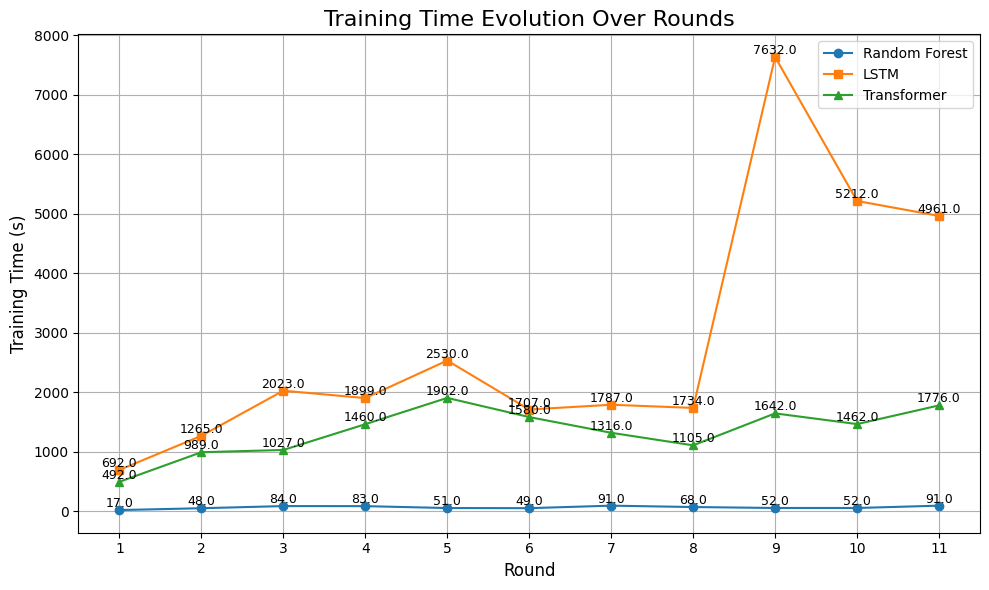

In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def parse_results_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    rounds_data = []
    round_blocks = re.split(r'Round \d+ Results Summary:', content)
    
    for i, block in enumerate(round_blocks):
        if not block.strip():
            continue
        
        round_num = i
        
        time_match = re.search(r'Training Time: (\d+)s', block)
        training_time = int(time_match.group(1)) if time_match else -1

        macro_match = re.search(r'macro avg\s*\|\s*Prec: .*?F1: ([\d\.]+)', block)
        f1_macro = float(macro_match.group(1)) if macro_match else -1

        class_f1_scores = {}
        class_lines = re.findall(r'(\w+)\s*\|\s*Prec: .*?F1: ([\d\.]+)', block)
        for class_name, f1_score in class_lines:
            if class_name.lower() not in ['accuracy', 'macro avg', 'weighted avg']:
                class_f1_scores[class_name] = float(f1_score)

        rounds_data.append({
            'round': round_num,
            'training_time': training_time,
            'f1_macro': f1_macro,
            'class_f1_scores': class_f1_scores
        })
        
    return pd.DataFrame(rounds_data)

def plot_performance_evolution(results_dict):
    
    plt.figure(figsize=(10, 6))

    for model_name, df in results_dict.items():
        plt.plot(df['round'], df['f1_macro'],
                 marker='o' if model_name == 'Random Forest' else 's' if model_name == 'LSTM' else '^',
                 linestyle='-', label=model_name)

        for x, y in zip(df['round'], df['f1_macro']):
            plt.text(x, y, f"{y:.3f}", fontsize=9, ha='center', va='bottom')

    plt.title('Macro F1 Score Evolution Over Rounds', fontsize=16)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('F1-Macro Score', fontsize=12)
    plt.xticks(range(1, 12))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("F1.png")
    plt.show()


def plot_training_time_evolution(results_dict):
    plt.figure(figsize=(10, 6))

    for model_name, df in results_dict.items():
        rounds = df['round']
        times = df['training_time']
        valid_points = times > 0
        plt.plot(rounds[valid_points], times[valid_points],
                 marker='o' if model_name == 'Random Forest' else 's' if model_name == 'LSTM' else '^',
                 linestyle='-', label=model_name)

        for x, y in zip(rounds[valid_points], times[valid_points]):
            plt.text(x, y, f"{y:.1f}", fontsize=9, ha='center', va='bottom')

    plt.title('Training Time Evolution Over Rounds', fontsize=16)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Training Time (s)', fontsize=12)
    plt.xticks(range(1, 12))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Training_time.png")
    plt.show()

if __name__ == '__main__':
    files = {
        "Random Forest": "RandomForest_Results.txt",
        "LSTM": "LSTM_Results.txt",
        "Transformer": "Transformer_Results.txt"
    }
    
    all_results = {}
    for model_name, file_path in files.items():
        all_results[model_name] = parse_results_file(file_path)   
    plot_performance_evolution(all_results)
    plot_training_time_evolution(all_results)
        


Retrain Models by the Optimal hyperparameters

In [9]:

# best parameters for Random Forest (from round 6)
best_rf_params = {
    "n_estimators": 300,
    "max_depth": 25,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
    "max_features": 5
}

# best parameters for LSTM (from round 11) 
best_lstm_params = {
    "units": 128,
    "dropout": 0.4,
    "recurrent_dropout": 0.2,
    "epochs": 20,
    "batch_size": 64,
    "gamma": 2.0,
    "alpha": 0.25,
    "learning_rate": 0.0005,
    "layers": 3
}

# best parameters for Transformer (from round 6)
best_transformer_params = {
    "num_heads": 2,
    "ff_dim": 128,
    "num_layers": 3,
    "dropout_rate": 0.3,
    "learning_rate": 0.0005,
    "epochs": 20,
    "activation": "relu",
    "batch_size": 64,
    "gamma": 2.0,
    "alpha": 0.25
}

print("\n Random Forest Training...")
best_rf_result = train_rf_model(X_rf_train, X_rf_test, y_rf_train, y_rf_test, params=best_rf_params)

print("\n LSTM Training...")
best_lstm_result = train_lstm_model(X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test, params=best_lstm_params)

print("\n Transformer Training...")
best_transformer_result = train_transformer_model(X_trans_train, y_trans_train, X_trans_test, y_trans_test, params=best_transformer_params)

for model_name, result in zip(['RandomForest', 'LSTM', 'Transformer'],[best_rf_result, best_lstm_result, best_transformer_result]):
    print(f"\n {model_name} Classification Report:")
    print(f" Training Time: {result.get('training_time', 0):.0f}s") 
    report = result['metrics']['classification_report']
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            support = metrics['support']
            print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
        else:
            print(f"{label:15} | {metrics:.4f}")


 Random Forest Training...

 LSTM Training...
Epoch 1/20


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.9652 - loss: 0.0230 - val_accuracy: 0.9735 - val_loss: 0.0107
Epoch 2/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9727 - loss: 0.0111 - val_accuracy: 0.9743 - val_loss: 0.0097
Epoch 3/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9738 - loss: 0.0102 - val_accuracy: 0.9754 - val_loss: 0.0092
Epoch 4/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9744 - loss: 0.0099 - val_accuracy: 0.9758 - val_loss: 0.0089
Epoch 5/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9746 - loss: 0.0097 - val_accuracy: 0.9760 - val_loss: 0.0087
Epoch 6/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9750 - loss: 0.0094 - val_accuracy: 0.9765 - val_loss: 0.0084
Epoch 7/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9755 - loss: 0.0091 - val_accuracy: 0.9769 - val_loss: 0.0083
Epoch 8/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.9756 - lo

In [10]:
# final features used for each model
models_info = [
    ("RandomForest", best_rf_result, best_rf_params, features_rf),
    ("LSTM", best_lstm_result, best_lstm_params, features_lstm),
    ("Transformer", best_transformer_result, best_transformer_params, features_transformer)
]

combined_results = {}

for model_name, result, params, features in models_info:
    combined_results[model_name] = {
        "training_time_sec": result.get("training_time", 0),
        "parameters": params,
        "features": features,
        "metrics": result["metrics"]
    }

# save the final results to a JSON file
filename = f"Assisted_Final_Results.json"
with open(filename, "w", encoding="utf-8") as f:
    json.dump(combined_results, f, indent=4, ensure_ascii=False)


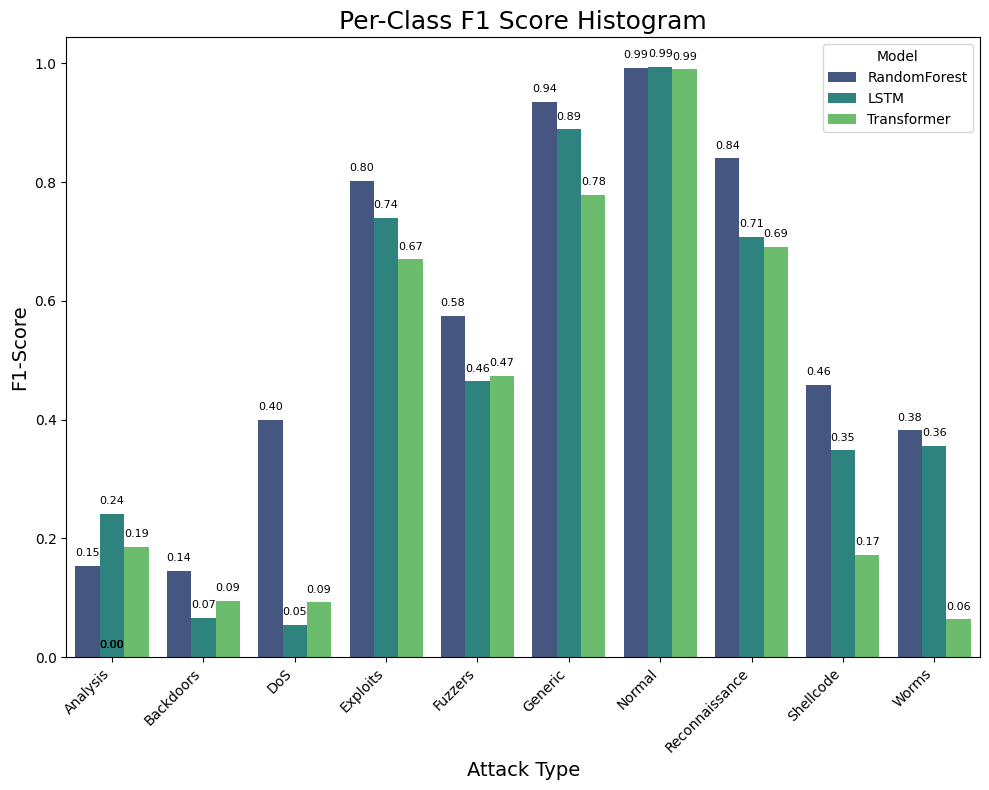

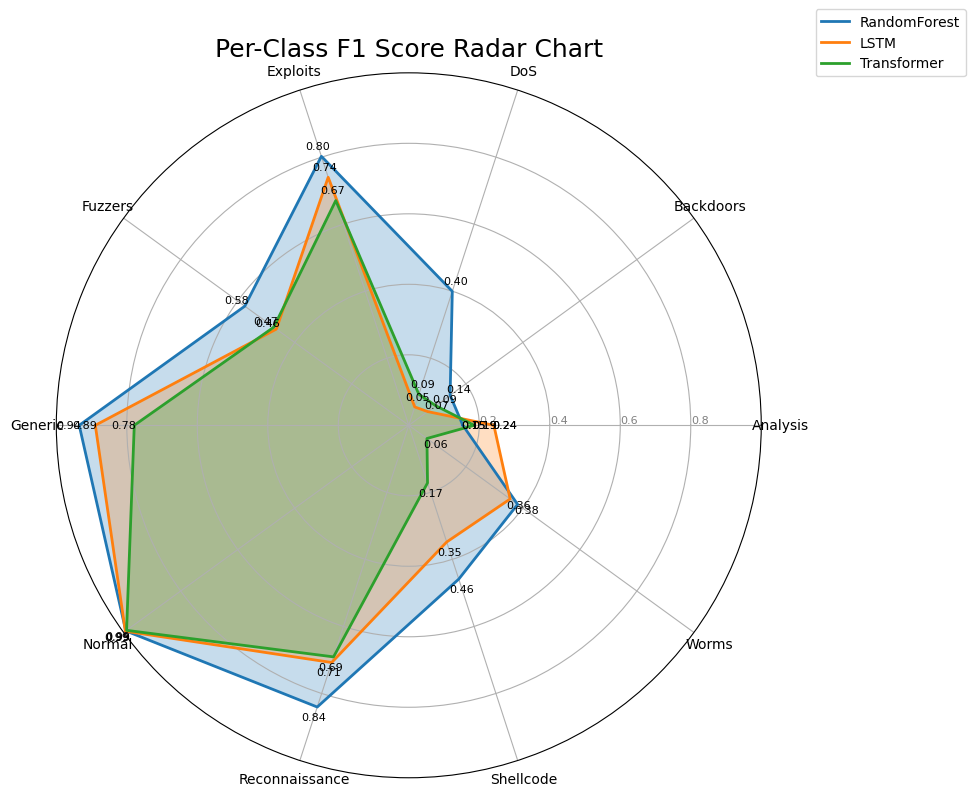

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

def plot_final_results_radar_chart(results_data):
    f1_scores = {}
    attack_labels = []

    # get per-class F1 scores from results_data
    for model_name, data in results_data.items():
        report = data['metrics']['classification_report']
        scores = {cls: report[cls]['f1-score'] for cls in report if isinstance(report[cls], dict)}
        f1_scores[model_name] = scores
        if not attack_labels:
            attack_labels = sorted([cls for cls in scores.keys() if cls not in ['accuracy', 'macro avg', 'weighted avg']])

    num_vars = len(attack_labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # draw radar chart
    for model_name, scores in f1_scores.items():
        values = [scores.get(label, 0) for label in attack_labels]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.25)

        for angle, value in zip(angles, values):
            ax.text(angle, value + 0.03, f"{value:.2f}", fontsize=8, ha='center', va='center')

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attack_labels, size=10)
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    ax.set_ylim(0, 1)

    plt.title('Per-Class F1 Score Radar Chart', fontsize=18)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

def plot_per_class_f1_comparison(results_data):
    f1_scores = {}
    attack_labels = []

    for model_name, data in results_data.items():
        report = data['metrics']['classification_report']
        scores = {cls: report[cls]['f1-score'] for cls in report if isinstance(report[cls], dict)}
        f1_scores[model_name] = scores
        if not attack_labels:
            attack_labels = sorted([cls for cls in scores.keys() if cls not in ['accuracy', 'macro avg', 'weighted avg']])
    
    plot_df_data = []
    for model_name, scores in f1_scores.items():
        for label in attack_labels:
            plot_df_data.append({
                'Model': model_name,
                'Attack Type': label,
                'F1-Score': scores.get(label, 0)
            })
    plot_df = pd.DataFrame(plot_df_data)
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=plot_df, x='Attack Type', y='F1-Score', hue='Model', palette='viridis')
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=8)

    plt.title('Per-Class F1 Score Histogram', fontsize=18)
    plt.xlabel('Attack Type', fontsize=14)
    plt.ylabel('F1-Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

final_results_path = "Assisted_Final_Results.json"
with open(final_results_path, 'r', encoding='utf-8') as f:
    final_results = json.load(f)
plot_per_class_f1_comparison(final_results)
plot_final_results_radar_chart(final_results)


Baseline：Manual + Initial Hyperparameter

In [ ]:
def baseline():
    # manually selected features for the models (30 features)
    manual_features = [
        'dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl',
        'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst',
        'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
        'trans_depth', 'res_bdy_len', 'ct_flw_http_mthd', 'is_ftp_login', 'dttl', 'is_sm_ips_ports', 'stime'
    ]
    # read and prepare the dataset
    df = pd.read_csv(r"C:\Users\yicheng\Desktop\data\csv\merged_cleaned_dataset.csv")
    X = df[manual_features]
    y = df["attack_cat"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    y_train = pd.Series(y_train).reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)

    # model training
    print("\n Training Random Forest...")
    rf_result = train_rf_model(X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

    print("\n Training LSTM...")
    lstm_result = train_lstm_model(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())

    print("\n Training Transformer...")
    transformer_result = train_transformer_model(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())

    # output the results
    print(f"\n Manual Selecting Results Summary:\n{'-'*60}")
    for model_name, result in zip(['RandomForest', 'LSTM', 'Transformer'],
                                  [rf_result, lstm_result, transformer_result]):
        print(f"\n {model_name} Classification Report:")
        print(f" Training Time: {result.get('training_time', 0):.0f}s") 
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")

    return {
        "features": manual_features,
        "rf": rf_result,
        "lstm": lstm_result,
        "transformer": transformer_result
    }

baseline_results = baseline()


 Training Random Forest...

 Training LSTM...


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9684 - loss: 0.0174 - val_accuracy: 0.9768 - val_loss: 0.0081
Epoch 2/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.9764 - loss: 0.0083 - val_accuracy: 0.9770 - val_loss: 0.0078
Epoch 3/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9771 - loss: 0.0079 - val_accuracy: 0.9778 - val_loss: 0.0073
Epoch 4/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9774 - loss: 0.0076 - val_accuracy: 0.9781 - val_loss: 0.0072
Epoch 5/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9778 - loss: 0.0074 - val_accuracy: 0.9784 - val_loss: 0.0071
Epoch 6/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9780 - loss: 0.0074 - val_accuracy: 0.9788 - val_loss: 0.0069
Epoch 7/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9782 - loss: 0.0072 - val_accuracy: 0.9788 - val_loss: 0.0070
Epoch 8/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 

Verify the Validity of Agent1：Agent1 + Initial Hyperparameter

In [39]:
print("\n Training Random Forest...")
baselin1_rf_result = train_rf_model(X_rf_train, X_rf_test,  y_rf_train, y_rf_test)

print("\n Training LSTM...")
baseline1_lstm_result = train_lstm_model(X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test)

print("\n Training Transformer...")
baseline1_transformer_result = train_transformer_model(X_trans_train, y_trans_train, X_trans_test, y_trans_test)

for model_name, result in zip(['RandomForest', 'LSTM', 'Transformer'],[baselin1_rf_result, baseline1_lstm_result, baseline1_transformer_result]):
    print(f"\n {model_name} Classification Report:")
    print(f" Training Time: {result.get('training_time', 0):.0f}s") 
    report = result['metrics']['classification_report']
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            support = metrics['support']
            print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
        else:
            print(f"{label:15} | {metrics:.4f}")
models_info = [
    ("RandomForest", baselin1_rf_result,features_rf),
    ("LSTM", baseline1_lstm_result, features_lstm),
    ("Transformer", baseline1_transformer_result, features_transformer)
]

combined_results = {}

for model_name, result, features in models_info:
    combined_results[model_name] = {
        "training_time_sec": result.get("training_time", 0),
        "features": features,
        "metrics": result["metrics"]
    }

# save the final results to a JSON file
filename = f"Agent1_Results.json"
with open(filename, "w", encoding="utf-8") as f:
    json.dump(combined_results, f, indent=4, ensure_ascii=False)


 Training Random Forest...

 Training LSTM...
Epoch 1/20


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25743/25743 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9642 - loss: 0.0228 - val_accuracy: 0.9731 - val_loss: 0.0109
Epoch 2/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9727 - loss: 0.0113 - val_accuracy: 0.9739 - val_loss: 0.0103
Epoch 3/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9735 - loss: 0.0107 - val_accuracy: 0.9747 - val_loss: 0.0100
Epoch 4/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.9737 - loss: 0.0105 - val_accuracy: 0.9746 - val_loss: 0.0097
Epoch 5/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.9740 - loss: 0.0103 - val_accuracy: 0.9749 - val_loss: 0.0096
Epoch 6/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9742 - loss: 0.0101 - val_accuracy: 0.9756 - val_loss: 0.0094
Epoch 7/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9742 - loss: 0.0099 - val_accuracy: 0.9755 - val_loss: 0.0093
Epoch 8/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9748 - lo

Verify the Validity of Agent2: Optimal Features + Agent2

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
manual_features = [
        'dur', 'sbytes', 'dbytes', 'spkts', 'dpkts', 'sload', 'dload', 'smeansz', 'dmeansz', 'sttl',
        'state', 'service', 'proto', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 'ct_srv_dst',
        'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
        'trans_depth', 'res_bdy_len', 'ct_flw_http_mthd', 'is_ftp_login', 'dttl', 'is_sm_ips_ports', 'stime'
]

df = pd.read_csv(r"C:\Users\yicheng\Desktop\data\csv\merged_cleaned_dataset.csv")
X = df[manual_features]
y = df["attack_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

SUBSET_SIZE = 0.2 
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=SUBSET_SIZE,random_state=42, stratify=y_train )


In [29]:
def new_rf_training(X_rf_train, X_rf_test, y_rf_train, y_rf_test, n_rounds):

    from copy import deepcopy

    results = {"RandomForest": []}

    # initial parameters for RF
    param_rf = {"n_estimators": 100,"max_depth": 20,"min_samples_split": 4,"min_samples_leaf": 2,"max_features": 5}
    
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # Random Forest
        print("Training Random Forest...")
        rf_result = train_rf_model(X_rf_train.copy(), X_rf_test.copy(), y_rf_train.copy(), y_rf_test.copy(), deepcopy(param_rf))
        results['RandomForest'].append(rf_result)
        param_rf = param_improve("RandomForest", rf_result["metrics"], param_rf, rf_result.get("classification_report"), round_id=round_i + 1, history=results["RandomForest"], training_time=rf_result.get("training_time"))
        
        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['RandomForest'],
                                  [rf_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print(" Training Random Forest...")
    final_rf_result = train_rf_model(X_rf_train.copy(), X_rf_test.copy(), y_rf_train.copy(), y_rf_test.copy(), deepcopy(param_rf))
    results['RandomForest'].append(final_rf_result)

    # final result
    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['RandomForest'],
                                  [final_rf_result]):
        print(f" {model_name} Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")

    
    try:        
        filename = f"Agent2_RandomForest.txt"
        with open(filename, 'w', encoding='utf-8') as f:            
            # output the results
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}")

                # record hyperparameters and metrics
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")    
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                # detailed classification report
                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else:
                        f.write(f"{label:15} | {metrics:.4f}\n")
                
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")

    except Exception as e:
        print(f"\n Failed: {e}")

    return results

results = new_rf_training(X_train_subset, X_test, y_train_subset, y_test, n_rounds=10)


 Round 1 / 11
Training Random Forest...
Reasoning for [RandomForest]
Analysis: The accuracy has shown slight improvements with increased n_estimators and max_depth, but the changes are marginal. The highest accuracy was observed in Round 3 and Round 4 with n_estimators at 200 and 300, and max_depth at 30. However, Round 5 with max_depth set to null and n_estimators at 400 did not yield better accuracy, indicating potential overfitting or diminishing returns. Hypothesis: The model might benefit from a balance between complexity and overfitting control. To test this, I will revert to n_estimators of 300 and max_depth of 30, but I will adjust max_features to allow for more feature interactions, which might capture more complex patterns without excessive depth. Proposal: Set n_estimators to 300, max_depth to 30, and increase max_features to 7. Justification: This should maintain a balance between model complexity and generalization, possibly improving macro F1 by capturing more relevant f

In [30]:
def new_lstm_training(X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test, n_rounds):
    from copy import deepcopy
    results = {"LSTM": []}

    # initial parameters for LSTM
    param_lstm = {"units": 64,"dropout": 0.3,"recurrent_dropout": 0.2,"epochs": 20,"batch_size": 64,
                  "gamma": 2.0,"alpha": 0.25,"learning_rate": 0.001,"layers": 1}
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # LSTM
        print("Training LSTM...")
        lstm_result = train_lstm_model(X_lstm_train.copy(), y_lstm_train.copy(), X_lstm_test.copy(), y_lstm_test.copy(), deepcopy(param_lstm))
        results['LSTM'].append(lstm_result)
        param_lstm = param_improve("LSTM", lstm_result["metrics"], param_lstm, lstm_result['metrics'].get("classification_report"), round_i + 1, results["LSTM"], lstm_result.get("training_time"))

        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['LSTM'],
                                  [lstm_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print("Training LSTM...")
    final_lstm_result = train_lstm_model(X_lstm_train.copy(), y_lstm_train.copy(), X_lstm_test.copy(), y_lstm_test.copy(), deepcopy(param_lstm))
    results['LSTM'].append(final_lstm_result)

    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['LSTM'],
                                  [final_lstm_result]):
        print(f" {model_name} Final Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")
    try:        
        filename = f"Agent2_LSTM.txt"
        with open(filename, 'w', encoding='utf-8') as f:            
            
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}\n")
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                # detailed classification report
                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else: 
                        f.write(f"{label:15} | {metrics:.4f}\n")
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")
    except Exception as e:
        print(f"\n Failed: {e}")

    return results

results = new_lstm_training(X_train_subset, X_test, y_train_subset, y_test, n_rounds=10)


 Round 1 / 11
Training LSTM...
Epoch 1/20


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9514 - loss: 0.0378 - val_accuracy: 0.9757 - val_loss: 0.0094
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9747 - loss: 0.0097 - val_accuracy: 0.9763 - val_loss: 0.0086
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9752 - loss: 0.0089 - val_accuracy: 0.9763 - val_loss: 0.0083
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9756 - loss: 0.0086 - val_accuracy: 0.9767 - val_loss: 0.0082
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9766 - loss: 0.0085 - val_accuracy: 0.9761 - val_loss: 0.0081
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9767 - loss: 0.0081 - val_accuracy: 0.9770 - val_loss: 0.0080
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9766 - loss: 0.0081 - val_accuracy: 0.9770 - val_loss: 0.0080
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9774 - loss: 0.0080 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9539 - loss: 0.0368 - val_accuracy: 0.9751 - val_loss: 0.0095
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9741 - loss: 0.0099 - val_accuracy: 0.9761 - val_loss: 0.0088
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9750 - loss: 0.0094 - val_accuracy: 0.9762 - val_loss: 0.0085
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9759 - loss: 0.0089 - val_accuracy: 0.9767 - val_loss: 0.0083
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9761 - loss: 0.0086 - val_accuracy: 0.9762 - val_loss: 0.0083
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9766 - loss: 0.0083 - val_accuracy: 0.9764 - val_loss: 0.0081
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9767 - loss: 0.0084 - val_accuracy: 0.9768 - val_loss: 0.0081
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9771 - loss: 0.0080 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9588 - loss: 0.0364 - val_accuracy: 0.9744 - val_loss: 0.0096
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9737 - loss: 0.0101 - val_accuracy: 0.9760 - val_loss: 0.0087
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9749 - loss: 0.0092 - val_accuracy: 0.9766 - val_loss: 0.0082
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9751 - loss: 0.0089 - val_accuracy: 0.9764 - val_loss: 0.0081
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9752 - loss: 0.0086 - val_accuracy: 0.9768 - val_loss: 0.0080
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9750 - loss: 0.0087 - val_accuracy: 0.9765 - val_loss: 0.0079
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9760 - loss: 0.0083 - val_accuracy: 0.9770 - val_loss: 0.0077
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9757 - loss: 0.0083 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The 'macro F1' scores are missing, but the accuracy slightly improved from Round 1 to Round 3. The increase in dropout from 0.3 to 0.4 did not negatively impact accuracy, suggesting the model can handle more regularization. Adding a second layer in Round 3 improved accuracy, indicating potential for deeper models. However, without 'macro F1', I can't confirm if these changes improved performance on minority classes. Hypothesis: The model might benefit from further increasing complexity to capture more nuanced patterns, but we should be cautious of overfitting. Proposal: Increase 'layers' to 3 and slightly reduce 'learning_rate' to 0.0005 to stabilize training. Justification: More layers may enhance feature learning, and a lower learning rate can provide more stable convergence, potentially boosting 'macro F1'.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.2

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9570 - loss: 0.0508 - val_accuracy: 0.9737 - val_loss: 0.0111
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9728 - loss: 0.0116 - val_accuracy: 0.9753 - val_loss: 0.0096
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9734 - loss: 0.0105 - val_accuracy: 0.9758 - val_loss: 0.0089
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9744 - loss: 0.0098 - val_accuracy: 0.9761 - val_loss: 0.0086
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9749 - loss: 0.0092 - val_accuracy: 0.9762 - val_loss: 0.0084
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9750 - loss: 0.0090 - val_accuracy: 0.9764 - val_loss: 0.0083
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9754 - loss: 0.0088 - val_accuracy: 0.9763 - val_loss: 0.0081
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9753 - loss: 0.0087 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Over the rounds, the accuracy remained relatively stable, but no 'macro F1' scores were recorded, indicating a potential issue with metric tracking. The learning rate was reduced in Round 4, but this did not improve accuracy, suggesting it might be too low. The dropout rate was increased to combat overfitting, but further increase in model complexity (adding layers) did not yield better accuracy. Hypothesis: The learning rate might be too low for effective learning with the current model complexity. Proposal: Increase the learning rate back to 0.001 and reduce the number of layers to 2 to simplify the model. Justification: Increasing the learning rate should enhance learning dynamics, and reducing layers can prevent overfitting while still maintaining some complexity.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.001, 'layers': 2}

 R

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9596 - loss: 0.0356 - val_accuracy: 0.9754 - val_loss: 0.0094
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9743 - loss: 0.0099 - val_accuracy: 0.9760 - val_loss: 0.0085
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9749 - loss: 0.0093 - val_accuracy: 0.9760 - val_loss: 0.0083
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9754 - loss: 0.0089 - val_accuracy: 0.9763 - val_loss: 0.0081
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9748 - loss: 0.0086 - val_accuracy: 0.9764 - val_loss: 0.0080
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9758 - loss: 0.0084 - val_accuracy: 0.9763 - val_loss: 0.0079
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9758 - loss: 0.0084 - val_accuracy: 0.9764 - val_loss: 0.0077
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9757 - loss: 0.0082 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The macro F1 score has not been provided, but the accuracy has shown minimal improvement with changes in the dropout rate and number of layers. Increasing the number of layers to 3 in Round 4, along with a reduced learning rate, resulted in a decrease in accuracy. Hypothesis: The model might benefit from a slightly larger learning rate to potentially escape a local minimum, as the reduction in learning rate did not yield better results. Additionally, the model complexity with 3 layers might be too high, leading to overfitting. Proposal: I will revert the number of layers to 2 and increase the learning rate slightly to 0.0015. Justification: This change should provide a balance between model complexity and learning stability, potentially improving macro F1 by allowing the model to learn more effectively while avoiding overfitting.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9636 - loss: 0.0294 - val_accuracy: 0.9756 - val_loss: 0.0091
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9741 - loss: 0.0100 - val_accuracy: 0.9755 - val_loss: 0.0086
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9744 - loss: 0.0094 - val_accuracy: 0.9765 - val_loss: 0.0083
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9751 - loss: 0.0089 - val_accuracy: 0.9766 - val_loss: 0.0079
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9760 - loss: 0.0086 - val_accuracy: 0.9771 - val_loss: 0.0078
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9757 - loss: 0.0083 - val_accuracy: 0.9771 - val_loss: 0.0077
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9764 - loss: 0.0081 - val_accuracy: 0.9774 - val_loss: 0.0077
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9762 - loss: 0.0081 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9604 - loss: 0.0339 - val_accuracy: 0.9749 - val_loss: 0.0097
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9730 - loss: 0.0108 - val_accuracy: 0.9757 - val_loss: 0.0087
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9741 - loss: 0.0097 - val_accuracy: 0.9759 - val_loss: 0.0085
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9748 - loss: 0.0092 - val_accuracy: 0.9760 - val_loss: 0.0082
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9749 - loss: 0.0089 - val_accuracy: 0.9760 - val_loss: 0.0083
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9751 - loss: 0.0089 - val_accuracy: 0.9754 - val_loss: 0.0082
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9750 - loss: 0.0088 - val_accuracy: 0.9765 - val_loss: 0.0079
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9751 - loss: 0.0086 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Throughout the rounds, the accuracy has been relatively stable with minor fluctuations, but we lack 'macro F1' information, which is crucial for evaluating performance on imbalanced data. The increase in dropout in Round 7 did not lead to a significant improvement in accuracy, and the learning rate changes have not shown a clear trend of improvement. Hypothesis: The model might be underfitting due to high dropout and insufficient model complexity. Proposal: I will increase the number of LSTM layers to 3 to enhance model capacity and reduce the dropout rate to 0.3 to allow the model to learn more features. Justification: Increasing layers should provide the model with more capacity to learn complex patterns, and reducing dropout will help in capturing more information, potentially improving macro F1.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.3, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learnin

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9616 - loss: 0.0362 - val_accuracy: 0.9749 - val_loss: 0.0099
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9741 - loss: 0.0100 - val_accuracy: 0.9753 - val_loss: 0.0088
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9748 - loss: 0.0092 - val_accuracy: 0.9759 - val_loss: 0.0084
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9750 - loss: 0.0088 - val_accuracy: 0.9765 - val_loss: 0.0081
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9752 - loss: 0.0086 - val_accuracy: 0.9765 - val_loss: 0.0081
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9754 - loss: 0.0085 - val_accuracy: 0.9770 - val_loss: 0.0079
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9758 - loss: 0.0080 - val_accuracy: 0.9769 - val_loss: 0.0077
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9763 - loss: 0.0081 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: The 'macro F1' score has not been provided, which is critical for evaluating the model's performance on this imbalanced dataset. However, based on the accuracy trends, there's little improvement across rounds, and the model seems to be stagnating. Previous attempts to increase layers and adjust dropout have not yielded significant improvements. Hypothesis: The learning rate adjustments have not been optimal, potentially causing instability or insufficient exploration of the loss surface. Proposal: I will decrease the learning rate to 0.0008 from 0.001 to stabilize training and allow for finer adjustments. Additionally, I will revert the dropout rate to 0.4 from 0.5 to balance regularization and model capacity. Justification: A smaller learning rate should help achieve a more stable convergence, potentially improving macro F1 when it is evaluated, while a moderate dropout rate will help prevent overfitting without overly constraining the model's capacity.


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9568 - loss: 0.0405 - val_accuracy: 0.9754 - val_loss: 0.0097
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9739 - loss: 0.0102 - val_accuracy: 0.9760 - val_loss: 0.0087
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9743 - loss: 0.0094 - val_accuracy: 0.9739 - val_loss: 0.0096
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9746 - loss: 0.0090 - val_accuracy: 0.9763 - val_loss: 0.0085
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9757 - loss: 0.0086 - val_accuracy: 0.9767 - val_loss: 0.0080
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9753 - loss: 0.0087 - val_accuracy: 0.9764 - val_loss: 0.0080
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9762 - loss: 0.0083 - val_accuracy: 0.9769 - val_loss: 0.0078
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9761 - loss: 0.0082 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Across multiple rounds, the 'macro F1' score has not been reported, indicating a potential issue in evaluation or data logging. However, based on accuracy trends, the model seems to perform similarly across different configurations. The changes in learning rate and dropout have not significantly affected performance. Hypothesis: The lack of 'macro F1' suggests a need to focus on improving class-wise performance, potentially through increased model capacity and a learning rate adjustment for stability. Proposal: Increase 'layers' to 4 for more complex feature learning and decrease 'learning_rate' to 0.0007 for stable improvements. Justification: Increasing layers should enhance the model's ability to capture complex patterns, and a smaller learning rate should provide stability and better convergence, potentially improving 'macro F1'.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.4, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'g

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9580 - loss: 0.0446 - val_accuracy: 0.9734 - val_loss: 0.0118
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9722 - loss: 0.0122 - val_accuracy: 0.9748 - val_loss: 0.0103
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9733 - loss: 0.0111 - val_accuracy: 0.9749 - val_loss: 0.0096
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9735 - loss: 0.0103 - val_accuracy: 0.9754 - val_loss: 0.0090
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9745 - loss: 0.0097 - val_accuracy: 0.9747 - val_loss: 0.0089
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9737 - loss: 0.0095 - val_accuracy: 0.9759 - val_loss: 0.0085
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9746 - loss: 0.0091 - val_accuracy: 0.9759 - val_loss: 0.0084
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9749 - loss: 0

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Reasoning for [LSTM]
Analysis: Over the rounds, the 'macro F1' score was not provided, but accuracy slightly fluctuated. The increase in 'layers' and 'dropout' did not consistently improve accuracy, and the learning rate changes did not clearly enhance performance. Hypothesis: The lack of improvement suggests that the model might benefit from a more stable training process with better regularization. Proposal: I will decrease the learning rate to 0.0005 to ensure more stable and fine-grained updates, and slightly increase the dropout to 0.5 to prevent overfitting, especially with 2 layers. Justification: This change aims to improve model generalization and stability, potentially enhancing the 'macro F1' score, which is crucial for imbalanced datasets.
[LSTM] suggested new parameters: {'units': 64, 'dropout': 0.5, 'recurrent_dropout': 0.2, 'epochs': 20, 'batch_size': 64, 'gamma': 2.0, 'alpha': 0.25, 'learning_rate': 0.0005, 'layers': 2}

 Round 10 Results Summary:
----------------------

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5149/5149 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9511 - loss: 0.0504 - val_accuracy: 0.9746 - val_loss: 0.0105
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9728 - loss: 0.0114 - val_accuracy: 0.9756 - val_loss: 0.0093
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9743 - loss: 0.0102 - val_accuracy: 0.9756 - val_loss: 0.0091
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9745 - loss: 0.0095 - val_accuracy: 0.9762 - val_loss: 0.0086
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9744 - loss: 0.0095 - val_accuracy: 0.9763 - val_loss: 0.0084
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9750 - loss: 0.0092 - val_accuracy: 0.9764 - val_loss: 0.0083
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9756 - loss: 0.0089 - val_accuracy: 0.9764 - val_loss: 0.0082
Epoch 8/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9758 - loss: 0.0087 - val

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


 Round 11 Results Summary:
------------------------------------------------------------
 LSTM Final Classification Report:
Training Time: 301s
Analysis        | Prec: 0.1332  Rec: 0.1396  F1: 0.1363  Supp: 437.0
Backdoors       | Prec: 0.1200  Rec: 0.0076  F1: 0.0142  Supp: 397.0
DoS             | Prec: 0.1272  Rec: 0.1430  F1: 0.1346  Supp: 1133.0
Exploits        | Prec: 0.7506  Rec: 0.7344  F1: 0.7424  Supp: 5520.0
Fuzzers         | Prec: 0.4750  Rec: 0.2161  F1: 0.2971  Supp: 4359.0
Generic         | Prec: 0.9291  Rec: 0.8207  F1: 0.8715  Supp: 5076.0
Normal          | Prec: 0.9900  Rec: 0.9977  F1: 0.9938  Supp: 391955.0
Reconnaissance  | Prec: 0.6073  Rec: 0.7259  F1: 0.6613  Supp: 2671.0
Shellcode       | Prec: 0.6267  Rec: 0.1556  F1: 0.2493  Supp: 302.0
Worms           | Prec: 0.0000  Rec: 0.0000  F1: 0.0000  Supp: 34.0
accuracy        | 0.9770
macro avg       | Prec: 0.4759  Rec: 0.3941  F1: 0.4101  Supp: 411884.0
weighted avg    | Prec: 0.9737  Rec: 0.9770  F1: 0.9746  Supp:

In [31]:
def new_transformer_training(X_trans_train, X_trans_test, y_trans_train, y_trans_test, n_rounds):
    from copy import deepcopy
    results = {"Transformer": []}

    # initial parameters for Transformer
    param_transformer = {
        "num_heads": 2,
        "ff_dim": 64,
        "num_layers": 1,
        "dropout_rate": 0.3,
        "epochs": 20,
        "activation": 'relu',
        "learning_rate": 0.001,
        "batch_size": 64,
        "gamma": 2.0,
        "alpha": 0.25
    }
    for round_i in range(n_rounds):
        print(f"\n Round {round_i + 1} / {n_rounds+1}")

        # Transformer
        print("Training Transformer...")
        transformer_result = train_transformer_model(X_trans_train.copy(), y_trans_train.copy(), X_trans_test.copy(), y_trans_test.copy(), deepcopy(param_transformer))
        results['Transformer'].append(transformer_result)
        param_transformer = param_improve("Transformer", transformer_result["metrics"], param_transformer, transformer_result['metrics'].get("classification_report"), round_i + 1, results["Transformer"], transformer_result.get("training_time"))

        # print each model's results
        print(f"\n Round {round_i+1} Results Summary:\n{'-'*60}")
        for model_name, result in zip(['Transformer'],
                                  [transformer_result]):
            print(f" {model_name} Classification Report:")
            print(f"Training Time: {result['training_time']:.0f}s")
            report = result['metrics']['classification_report']
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    precision = metrics['precision']
                    recall = metrics['recall']
                    f1 = metrics['f1-score']
                    support = metrics['support']
                    print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
                else:
                    print(f"{label:15} | {metrics:.4f}")

    # final round after n_rounds
    print(f"\n Round {n_rounds + 1} / {n_rounds+1}")
    print("Training Transformer...")
    final_transformer_result = train_transformer_model(X_trans_train.copy(), y_trans_train.copy(), X_trans_test.copy(), y_trans_test.copy(), deepcopy(param_transformer))
    results['Transformer'].append(final_transformer_result)

    print(f"\n Round {n_rounds+1} Results Summary:\n{'-'*60}")
    for model_name, result in zip(['Transformer'],
                                  [final_transformer_result]):
        print(f" {model_name} Classification Report:")
        print(f"Training Time: {result['training_time']:.0f}s")
        report = result['metrics']['classification_report']
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                precision = metrics['precision']
                recall = metrics['recall']
                f1 = metrics['f1-score']
                support = metrics['support']
                print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
            else:
                print(f"{label:15} | {metrics:.4f}")

    # save results            
    try:        
        filename = f"Agent2_Transformer.txt"
        with open(filename, 'w', encoding='utf-8') as f:        
            for i, round_result in enumerate(results[model_name]):
                round_num = i + 1
                f.write(f" Round {round_num} Results Summary:\n{'-'*60}\n")
                params = round_result.get('params', {})
                f.write("parameters: \n")
                f.write(json.dumps(params, indent=4) + "\n")
                training_time = round_result.get('training_time', 0)
                f.write(f"Training Time: {training_time:.0f}s\n")

                report = round_result.get('metrics', {}).get('classification_report', {})
                for label, metrics in report.items():
                    if isinstance(metrics, dict):
                        precision = metrics.get('precision', 0)
                        recall = metrics.get('recall', 0)
                        f1 = metrics.get('f1-score', 0)
                        support = metrics.get('support', 0)
                        f.write(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {int(support)}\n")
                    else: 
                        f.write(f"{label:15} | {metrics:.4f}\n")
                f.write("\n\n") 
        print(f"\n Successfully save {filename}")
    except Exception as e:
        print(f"\n Failed: {e}")
    return results

results = new_transformer_training(X_train_subset, X_test, y_train_subset, y_test, n_rounds=10)



 Round 1 / 11
Training Transformer...
Epoch 1/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 89s 17ms/step - accuracy: 0.9067 - loss: 9.8635e-04 - val_accuracy: 0.9549 - val_loss: 6.2183e-04
Epoch 2/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.9400 - loss: 6.1508e-04 - val_accuracy: 0.9463 - val_loss: 5.5512e-04
Epoch 3/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 97s 19ms/step - accuracy: 0.9457 - loss: 5.4009e-04 - val_accuracy: 0.9549 - val_loss: 5.8313e-04
Epoch 4/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 146s 20ms/step - accuracy: 0.9421 - loss: 5.5552e-04 - val_accuracy: 0.9521 - val_loss: 4.8304e-04
Epoch 5/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 100s 19ms/step - accuracy: 0.9484 - loss: 5.3346e-04 - val_accuracy: 0.9541 - val_loss: 4.9377e-04
Epoch 6/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - accuracy: 0.9486 - loss: 4.7980e-04 - val_accuracy: 0.9551 - val_loss: 4.4816e-04
Epoch 7/20
5149/5149 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - accuracy: 0.9476 - loss: 5.0187e-04 - val_accuracy: 0.9556 

In [33]:
# best parameters for RandomForest (from round 11)
new_rf_params = {
    "n_estimators": 300,
    "max_depth": 30,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
    "max_features": 40
}

# best parameters for LSTM (from round 8)
new_lstm_params = {
    "units": 64,
    "dropout": 0.3,
    "recurrent_dropout": 0.2,
    "epochs": 20,
    "batch_size": 64,
    "gamma": 2.0,
    "alpha": 0.25,
    "learning_rate": 0.001,
    "layers": 3
}

# best parameters for Transformer (from round 7)
new_transformer_params = {
    "num_heads": 2,
    "ff_dim": 128,
    "num_layers": 2,
    "dropout_rate": 0.4,
    "learning_rate": 0.0003,
    "epochs": 20,
    "activation": "relu",
    "batch_size": 64,
    "gamma": 2.0,
    "alpha": 0.25
}

print("\n Random Forest Training...")
new_rf_result = train_rf_model(X_train, X_test, y_train, y_test, params=new_rf_params)

print("\n LSTM Training...")
new_lstm_result = train_lstm_model(X_train, y_train, X_test, y_test, params=new_lstm_params)

print("\n Transformer Training...")
new_transformer_result = train_transformer_model(X_train, y_train, X_test, y_test, params=new_transformer_params)

for model_name, result in zip(['RandomForest', 'LSTM', 'Transformer'],[new_rf_result, new_lstm_result, new_transformer_result]):
    print(f"\n {model_name} Classification Report:")
    print(f" Training Time: {result.get('training_time', 0):.0f}s") 
    report = result['metrics']['classification_report']
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            support = metrics['support']
            print(f"{label:15} | Prec: {precision:.4f}  Rec: {recall:.4f}  F1: {f1:.4f}  Supp: {support}")
        else:
            print(f"{label:15} | {metrics:.4f}")
models_info = [
    ("RandomForest", new_rf_result, new_rf_params, manual_features),
    ("LSTM", new_lstm_result, new_lstm_params, manual_features),
    ("Transformer", new_transformer_result, new_transformer_params, manual_features)
]

combined_results = {}

for model_name, result, params, features in models_info:
    combined_results[model_name] = {
        "training_time_sec": result.get("training_time", 0),
        "parameters": params,
        "features": features,
        "metrics": result["metrics"]
    }

# save the final results to a JSON file
filename = f"Agent2_Results.json"
with open(filename, "w", encoding="utf-8") as f:
    json.dump(combined_results, f, indent=4, ensure_ascii=False)


 Random Forest Training...

 LSTM Training...


C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.9702 - loss: 0.0173 - val_accuracy: 0.9764 - val_loss: 0.0078
Epoch 2/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - accuracy: 0.9758 - loss: 0.0084 - val_accuracy: 0.9780 - val_loss: 0.0074
Epoch 3/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - accuracy: 0.9769 - loss: 0.0078 - val_accuracy: 0.9785 - val_loss: 0.0071
Epoch 4/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9771 - loss: 0.0076 - val_accuracy: 0.9780 - val_loss: 0.0069
Epoch 5/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - accuracy: 0.9776 - loss: 0.0074 - val_accuracy: 0.9776 - val_loss: 0.0069
Epoch 6/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - accuracy: 0.9775 - loss: 0.0074 - val_accuracy: 0.9785 - val_loss: 0.0067
Epoch 7/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - accuracy: 0.9776 - loss: 0.0073 - val_accuracy: 0.9785 - val_loss: 0.0066
Epoch 8/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 

C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yicheng\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


 Transformer Training...
Epoch 1/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 240s 9ms/step - accuracy: 0.9122 - loss: 8.5101e-04 - val_accuracy: 0.9585 - val_loss: 5.4591e-04
Epoch 2/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 247s 10ms/step - accuracy: 0.9476 - loss: 5.0538e-04 - val_accuracy: 0.9592 - val_loss: 5.0330e-04
Epoch 3/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 254s 10ms/step - accuracy: 0.9508 - loss: 5.1626e-04 - val_accuracy: 0.9629 - val_loss: 5.4165e-04
Epoch 4/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.9516 - loss: 4.9903e-04 - val_accuracy: 0.9622 - val_loss: 4.8744e-04
Epoch 5/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 225s 9ms/step - accuracy: 0.9537 - loss: 4.9288e-04 - val_accuracy: 0.9653 - val_loss: 4.5694e-04
Epoch 6/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.9551 - loss: 4.7510e-04 - val_accuracy: 0.9683 - val_loss: 4.3199e-04
Epoch 7/20
25743/25743 ━━━━━━━━━━━━━━━━━━━━ 258s 10ms/step - accuracy: 0.9571 - loss: 4.7023e-04 - val_accuracy: 0.9683 